# Fabric Classification with MIL + Swin Transformer
## Description of File
### Key features
*   Multiple Instance Learning with attention and confidence voting aggregators
*   Supports pretrained backbones by timm
*   Stratified k-fold validation
*   Disk image caching for speed and drive-friendly integration
*   Early stopping, gradient accumulation, class rebalancing
*   Grad-CAM visualizations to inspect feature focus


### Model Architecture
Image -> Feature extractor (EfficientNet, Eva, Swin) -> Instance embedding -> MIL Aggregation (GatedAttention, SoftMax, Noisy-AND, Confidence voting) -> Bag level prediction (7 fabric classes)


### After training visualizations
* Attention Maps
* Confusion Matrices
* Metrics breakdown per class and fold


In [ ]:
# ============================================================================
# Configuration
# ============================================================================

# Image size for model input (EfficientNet-B3 native is 300, use 224 for faster iteration)
IMAGE_SIZE = 224

# Pre-resize before cropping (slightly larger than IMAGE_SIZE for crop margin)
PRE_RESIZE = int(IMAGE_SIZE * 1.12)

# Random crop scale range for training augmentation
CROP_SCALE_MIN = 0.7  # Some zoom to focus on fabric, but not too blurry
CROP_SCALE_MAX = 0.95  # Allow near-full image for context

print(f" Image config: PRE_RESIZE={PRE_RESIZE}, IMAGE_SIZE={IMAGE_SIZE}, crop_scale=({CROP_SCALE_MIN}, {CROP_SCALE_MAX})")


 Image config: PRE_RESIZE=250, IMAGE_SIZE=224, crop_scale=(0.7, 0.95)


In [ ]:

try:
    import timm
except ImportError:
    %pip install timm --quiet

# Ensure zstd is installed for fast archive extraction
import subprocess
if subprocess.run(['which', 'zstd'], capture_output=True).returncode != 0:
    print("Installing zstd...")
    !apt-get update -qq && apt-get install -y -qq zstd
    print(" zstd installed")

import timm
import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms

from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import (accuracy_score, precision_recall_fscore_support,
                             roc_auc_score, confusion_matrix, classification_report)

import pandas as pd
import numpy as np
from pathlib import Path
import os
from PIL import Image
from tqdm import tqdm
import json
from collections import defaultdict, Counter

Installing zstd...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)
Selecting previously unselected package zstd.
(Reading database ... 121713 files and directories currently installed.)
Preparing to unpack .../zstd_1.4.8+dfsg-3build1_amd64.deb ...
Unpacking zstd (1.4.8+dfsg-3build1) ...
Setting up zstd (1.4.8+dfsg-3build1) ...
Processing triggers for man-db (2.10.2-1) ...
 zstd installed


In [ ]:
from google.colab import drive
import shutil
import os
import subprocess

# Mount Google Drive
drive.mount('/content/drive')

path_prefix = "/content/drive/MyDrive/CSCI 461 Project/cynthia-model/"
csv_path = path_prefix + "fiber_data.csv"

# Archive path (.tar.zst for fast multi-threaded extraction)
zst_file_gdrive_path = path_prefix + "fiber_images.tar.zst"
local_images_folder = "/content/fiber_images"

# Check if the local images folder already exists
if not os.path.exists(local_images_folder):
    print(f" Local image folder not found. Extracting from archive...")

    if not os.path.exists(zst_file_gdrive_path):
        raise FileNotFoundError(f" Archive not found: {zst_file_gdrive_path}\n"
                                f"Please create it with: tar -I 'zstd -T0 -19' -cf fiber_images.tar.zst fiber_images/")

    local_zst_path = "/content/fiber_images.tar.zst"

    # Copy to local SSD first (faster than extracting directly from Drive)
    if os.path.exists(local_zst_path):
        archive_size_mb = os.path.getsize(local_zst_path) / (1024 * 1024)
        print(f"   Archive already on local SSD ({archive_size_mb:.1f} MB)")
    else:
        print(f"  Copying archive to local SSD...")
        shutil.copyfile(zst_file_gdrive_path, local_zst_path)
        archive_size_mb = os.path.getsize(local_zst_path) / (1024 * 1024)
        print(f"   Copied ({archive_size_mb:.1f} MB)")

    # Extract with zstd multi-threaded (-T0 = all cores)
    print(f"  Extracting with zstd (multi-threaded)...")
    print(local_zst_path)
    result = subprocess.run(
        ['tar', '-I', 'zstd -T0', '-xf', local_zst_path, '-C', '/content/'],
        capture_output=True, text=True
    )

    if result.returncode != 0:
        # Try alternative tar syntax
        result = subprocess.run(
            ['tar', '--zstd', '-xf', local_zst_path, '-C', '/content/'],
            capture_output=True, text=True
        )

    if result.returncode != 0:
        raise RuntimeError(f" Extraction failed:\n{result.stderr}")

    # Cleanup local archive
    os.remove(local_zst_path)

    # Count extracted files
    num_files = len([f for f in os.listdir(local_images_folder) if f.endswith('.jpg')])
    print(f"   Extracted {num_files} images to {local_images_folder}")

else:
    num_files = len([f for f in os.listdir(local_images_folder) if f.endswith('.jpg')])
    print(f" {local_images_folder} exists ({num_files} images), skipping extraction.")

images_folder=local_images_folder

Mounted at /content/drive
 Local image folder not found. Extracting from archive...
  Copying archive to local SSD...
   Copied (5069.4 MB)
  Extracting with zstd (multi-threaded)...
/content/fiber_images.tar.zst
   Extracted 13199 images to /content/fiber_images


In [ ]:
# ============================================================================
# MIL Aggregation Modules
# ============================================================================

class NoisyAnd(torch.nn.Module):
    def __init__(self, a=10, dims=[1,2]):
        super(NoisyAnd, self).__init__()
        self.a = a
        self.b = torch.nn.Parameter(torch.tensor(0.01))
        self.dims = dims
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        mean = torch.mean(x, self.dims, True)
        res = (self.sigmoid(self.a * (mean - self.b)) - self.sigmoid(-self.a * self.b)) / (
              self.sigmoid(self.a * (1 - self.b)) - self.sigmoid(-self.a * self.b))
        return res


class AttentionSoftMax(torch.nn.Module):
    def __init__(self, in_features=512, out_features=None):
        """
        Attention-based aggregation for MIL
        Given tensor [N x M] where N=instances, M=features
        Returns: aggregated features [M] and attention weights [N]
        """
        super(AttentionSoftMax, self).__init__()
        self.otherdim = ''
        if out_features is None:
            out_features = in_features
        self.layer_linear_tr = nn.Linear(in_features, out_features)
        self.activation = nn.LeakyReLU()
        self.layer_linear_query = nn.Linear(out_features, 1)

    def forward(self, x):
        keys = self.layer_linear_tr(x)
        keys = self.activation(keys)
        attention_map_raw = self.layer_linear_query(keys)[..., 0]
        attention_map = nn.Softmax(dim=-1)(attention_map_raw)
        result = torch.einsum(f'{self.otherdim}i,{self.otherdim}ij->{self.otherdim}j',
                            attention_map, x)
        return result, attention_map


class GatedAttention(nn.Module):
    def __init__(self, L=512, D=128, K=1):
        """
        Gated Attention Mechanism (Ilse et al., 2018)
        L: Input feature dimension
        D: Hidden dimension for attention
        K: Output dimension (usually 1 for attention score)
        """
        super(GatedAttention, self).__init__()
        self.L = L
        self.D = D
        self.K = K

        self.attention_V = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Tanh()
        )

        self.attention_U = nn.Sequential(
            nn.Linear(self.L, self.D),
            nn.Sigmoid()
        )

        self.attention_weights = nn.Linear(self.D, self.K)

    def forward(self, x):
        # x: [N, L]
        A_V = self.attention_V(x)  # N x D
        A_U = self.attention_U(x)  # N x D

        # Gating mechanism: Tanh(V) * Sigmoid(U)
        A = self.attention_weights(A_V * A_U) # N x K
        A = torch.transpose(A, 1, 0)  # K x N
        A = nn.functional.softmax(A, dim=1)  # softmax over N

        M = torch.mm(A, x)  # K x L => [1, L]
        M = M.squeeze(0)    # [L]

        return M, A.transpose(1, 0).squeeze(1) # Return feature [L] and attention [N]


class ConfidenceWeightedVoting(torch.nn.Module):
    def __init__(self, in_features=512, n_classes=5):
        """
        Confidence-weighted majority voting aggregation for multiclass classification
        """
        super(ConfidenceWeightedVoting, self).__init__()
        self.n_classes = n_classes
        self.instance_classifier = nn.Sequential(
            nn.Linear(in_features, 256),  # Hidden layer
            nn.ReLU(),
            nn.Dropout(0.5),  # Increased dropout
            nn.Linear(256, n_classes)
        )

    def forward(self, x):
        """
        Args:
            x: Instance features [n_instances, feature_dim]
        Returns:
            aggregated_votes: Weighted vote distribution [n_classes]
            instance_votes: Instance predictions and confidences for interpretation
        """
        # Get logits for each instance
        instance_logits = self.instance_classifier(x)  # [n_instances, n_classes]

        # Get probabilities (confidences) for each instance's predictions
        instance_probs = torch.softmax(instance_logits, dim=-1)  # [n_instances, n_classes]

        # Get predicted class for each instance
        instance_predictions = torch.argmax(instance_probs, dim=-1)  # [n_instances]

        # Get confidence (max probability) for each instance's prediction
        instance_confidences = torch.max(instance_probs, dim=-1)[0]  # [n_instances]

        # Aggregate logits across instances (stable, works with CrossEntropyLoss)
        aggregated_logits = torch.logsumexp(instance_logits, dim=0)  # [n_classes]

        # Store instance-level information for interpretation
        instance_votes = {
            'predictions': instance_predictions,
            'confidences': instance_confidences,
            'probabilities': instance_probs
        }

        return aggregated_logits, instance_votes

class SoftMaxMeanSimple(torch.nn.Module):
    def __init__(self, n, n_inst, dim=0):
        """
        Learnable weighted mean aggregation
        """
        super(SoftMaxMeanSimple, self).__init__()
        self.dim = dim
        self.gate = torch.nn.Softmax(dim=self.dim)
        self.mdl_instance_transform = nn.Sequential(
            nn.Linear(n, n_inst),
            nn.LeakyReLU(),
            nn.Linear(n_inst, 1),  # Output 1 score per instance
            nn.LeakyReLU(),
        )

    def forward(self, x):
        # x shape: [n_instances, feature_dim]
        z = self.mdl_instance_transform(x)  # [n_instances, 1]
        z = z.squeeze(-1)  # [n_instances]
        gate_ = self.gate(z)  # [n_instances] - attention weights

        # Expand gate for multiplication
        gate_expanded = gate_.unsqueeze(-1)  # [n_instances, 1]
        res = torch.sum(x * gate_expanded, self.dim)  # [feature_dim]

        return res, gate_

In [ ]:
# ============================================================================
# Bag Classifier Modules
# ============================================================================

class NN(torch.nn.Module):
    def __init__(self, n=512, n_mid=1024, n_out=1, dropout=0.2, scoring=None):
        super(NN, self).__init__()
        self.linear1 = torch.nn.Linear(n, n_mid)
        self.non_linearity = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(n_mid, n_out)
        self.dropout = torch.nn.Dropout(dropout)

    def forward(self, x):
        z = self.linear1(x)
        z = self.non_linearity(z)
        z = self.dropout(z)
        z = self.linear2(z)
        return z


class LogisticRegression(torch.nn.Module):
    def __init__(self, n=512, n_out=1):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(n, n_out)

    def forward(self, x):
        z = self.linear(x)
        return z


def regularization_loss(params, reg_factor=0.005, reg_alpha=0.5):
    params = [pp for pp in params if len(pp.shape) > 1]
    l1_reg = nn.L1Loss()
    l2_reg = nn.MSELoss()
    loss_reg = 0
    for pp in params:
        loss_reg += reg_factor * ((1 - reg_alpha) * l1_reg(pp, target=torch.zeros_like(pp)) +
                                 reg_alpha * l2_reg(pp, target=torch.zeros_like(pp)))
    return loss_reg


In [ ]:
# ============================================================================
# Focal Loss for Class Imbalance (Lin et al., 2017)
# ============================================================================
import torch.nn.functional as F

class FocalLoss(nn.Module):
    def __init__(self, alpha=None, gamma=2.0, reduction='mean', label_smoothing=0.0):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction
        self.label_smoothing = label_smoothing

    def forward(self, inputs, targets):
        """
        Args:
            inputs: Raw logits [batch_size, num_classes]
            targets: Ground truth labels [batch_size]
        """
        num_classes = inputs.size(-1)

        # Apply label smoothing if specified
        if self.label_smoothing > 0:
            # Convert targets to one-hot
            targets_one_hot = F.one_hot(targets, num_classes).float()
            # Apply smoothing
            targets_smooth = targets_one_hot * (1 - self.label_smoothing) + self.label_smoothing / num_classes
            # Compute log softmax
            log_probs = F.log_softmax(inputs, dim=-1)
            # Compute cross entropy with smoothed targets
            ce_loss = -(targets_smooth * log_probs).sum(dim=-1)
            # Get probabilities for focal weighting
            probs = torch.exp(log_probs)
            # Use the probability of the true class for focal weight
            pt = (targets_one_hot * probs).sum(dim=-1)
        else:
            # Standard cross entropy
            ce_loss = F.cross_entropy(inputs, targets, weight=self.alpha, reduction='none')
            # Get probability of true class
            probs = F.softmax(inputs, dim=-1)
            pt = probs.gather(1, targets.unsqueeze(1)).squeeze(1)

        # Focal weight: (1 - pt)^gamma
        focal_weight = (1 - pt) ** self.gamma

        # Apply alpha weighting if provided (and not already applied via CE)
        if self.alpha is not None and self.label_smoothing > 0:
            alpha_weight = self.alpha.gather(0, targets)
            focal_loss = alpha_weight * focal_weight * ce_loss
        else:
            focal_loss = focal_weight * ce_loss

        # Reduction
        if self.reduction == 'mean':
            return focal_loss.mean()
        elif self.reduction == 'sum':
            return focal_loss.sum()
        else:
            return focal_loss


# Quick test
if __name__ == "__main__":
    # Test focal loss
    _inputs = torch.randn(4, 6)  # batch=4, classes=6
    _targets = torch.tensor([0, 1, 2, 3])
    _alpha = torch.tensor([1.0, 2.0, 3.0, 2.0, 2.5, 3.0])

    fl = FocalLoss(alpha=_alpha, gamma=2.0, label_smoothing=0.05)
    loss = fl(_inputs, _targets)
    print(f" Focal Loss test: {loss.item():.4f}")


 Focal Loss test: 4.4934


In [ ]:
# ============================================================================
# Cache Backup/Restore Functions (Google Drive persistence)
# ============================================================================

def restore_cache_from_drive(local_cache_dir, drive_cache_archive):
    """
    Restore disk cache from a .tar.zst archive on Google Drive.
    Returns True if cache was restored, False otherwise.
    """
    import shutil
    import subprocess

    if not os.path.exists(drive_cache_archive):
        print(f"  No cache archive found at {drive_cache_archive}")
        return False

    if os.path.exists(local_cache_dir) and len(os.listdir(local_cache_dir)) > 0:
        print(f"  Local cache already exists ({len(os.listdir(local_cache_dir))} files), skipping restore")
        return True

    print(f"  Restoring cache from Google Drive...")
    os.makedirs(local_cache_dir, exist_ok=True)

    # Copy archive to local SSD first (faster extraction)
    local_archive = "/content/image_cache.tar.zst"
    shutil.copyfile(drive_cache_archive, local_archive)
    archive_size_mb = os.path.getsize(local_archive) / (1024 * 1024)
    print(f"   Copied archive ({archive_size_mb:.1f} MB)")

    # Extract
    result = subprocess.run(
        ['tar', '-I', 'zstd -T0', '-xf', local_archive, '-C', '/content/'],
        capture_output=True, text=True
    )

    if result.returncode != 0:
        result = subprocess.run(
            ['tar', '--zstd', '-xf', local_archive, '-C', '/content/'],
            capture_output=True, text=True
        )

    os.remove(local_archive)

    if result.returncode == 0:
        num_files = len(os.listdir(local_cache_dir)) if os.path.exists(local_cache_dir) else 0
        print(f"   Restored {num_files} cached images")
        return True
    else:
        print(f"   Cache restore failed: {result.stderr}")
        return False


def backup_cache_to_drive(local_cache_dir, drive_cache_archive):
    """
    Archive the local disk cache and save to Google Drive.
    Only runs if no valid archive exists yet.
    """
    import shutil
    import subprocess

    if not os.path.exists(local_cache_dir):
        print("  No local cache to backup")
        return

    num_cached = len([f for f in os.listdir(local_cache_dir) if f.endswith('.pkl')])
    if num_cached == 0:
        print("  Cache is empty, skipping backup")
        return

    # Check if backup is needed
    if os.path.exists(drive_cache_archive):
        archive_size_mb = os.path.getsize(drive_cache_archive) / (1024 * 1024)
        if archive_size_mb > 10:  # If archive > 10MB, assume it's valid
            print(f"  Cache archive exists ({archive_size_mb:.1f} MB), skipping backup")
            print(f"  (Delete {drive_cache_archive} to force re-backup)")
            return

    print(f"  Backing up {num_cached} cached images to Google Drive...")

    local_archive = "/content/image_cache_backup.tar.zst"

    result = subprocess.run(
        ['tar', '-I', 'zstd -T0 -3', '-cf', local_archive, '-C', '/content/', 'image_cache'],
        capture_output=True, text=True
    )

    if result.returncode != 0:
        print(f"   Archive creation failed: {result.stderr}")
        return

    archive_size_mb = os.path.getsize(local_archive) / (1024 * 1024)
    print(f"   Created archive ({archive_size_mb:.1f} MB)")

    shutil.copyfile(local_archive, drive_cache_archive)
    os.remove(local_archive)
    print(f"   Backup complete: {drive_cache_archive}")


In [ ]:
# ============================================================================
# MIL Model for Fabric Classification (Multi-Backbone Support)
# ============================================================================

BACKBONE_CONFIGS = {
    # timm: `efficientnet_b3` backbone, 1536-d features
    'efficientnet_b3': {
        'model_name': 'efficientnet_b3',
        'feature_dim': 1536,
        'native_size': None,
    },

    # timm: TF EfficientNetV2 variants; 1280-d features is correct
    'efficientnetv2_s': {
        'model_name': 'tf_efficientnetv2_s',
        'feature_dim': 1280,
        'native_size': None,
    },
    'efficientnetv2_m': {
        'model_name': 'tf_efficientnetv2_m',
        'feature_dim': 1280,
        'native_size': None,
    },

    # timm ConvNeXt, 768-d features for tiny/small
    'convnext_tiny': {
        'model_name': 'convnext_tiny',
        'feature_dim': 768,
        'native_size': None,
    },
    'convnext_small': {
        'model_name': 'convnext_small',
        'feature_dim': 768,
        'native_size': None,
    },

    # --- Swin Transformers @ 224 (use with IMAGE_SIZE=224) ---
    'swin_tiny': {
        'model_name': 'swin_tiny_patch4_window7_224',
        'feature_dim': 768,
        'native_size': 224,
    },
    'swin_small': {
        'model_name': 'swin_small_patch4_window7_224',
        'feature_dim': 768,
        'native_size': 224,
    },
    'swin_base': {
        'model_name': 'swin_base_patch4_window7_224',
        'feature_dim': 1024,
        'native_size': 224,
    },

    # --- Swin Transformers @ 384 (use with IMAGE_SIZE=384) ---
    'swin_base_384': {
        'model_name': 'swin_base_patch4_window12_384',
        'feature_dim': 1024,
        'native_size': 384,
    },
    'swin_large_384': {
        'model_name': 'swin_large_patch4_window12_384',
        'feature_dim': 1536,
        'native_size': 384,
    },

    # --- EVA-02 @ 224 (use with IMAGE_SIZE=224) ---
    'eva02_tiny': {
        'model_name': 'eva02_tiny_patch14_224.mim_in22k',
        'feature_dim': 192,   # 257 x 192 unpooled → 192-d pooled
        'native_size': 224,
    },
    'eva02_small': {
        'model_name': 'eva02_small_patch14_224.mim_in22k',
        'feature_dim': 384,
        'native_size': 224,
    },
    'eva02_base': {
        'model_name': 'eva02_base_patch14_224.mim_in22k',
        'feature_dim': 768,
        'native_size': 224,
    },
    'eva02_large': {
        'model_name': 'eva02_large_patch14_224.mim_in22k',
        'feature_dim': 1024,
        'native_size': 224,
    },

    # --- EVA-02 @ 336 (true 336x336 EVA-02 variants) ---
    'eva02_tiny_336': {
        'model_name': 'eva02_tiny_patch14_336.mim_in22k_ft_in1k',
        'feature_dim': 192,
        'native_size': 336,
    },
    'eva02_small_336': {
        'model_name': 'eva02_small_patch14_336.mim_in22k_ft_in1k',
        'feature_dim': 384,
        'native_size': 336,
    },
}


class MIL_FabricClassifier(torch.nn.Module):
    def __init__(self, n_classes, pretrained_path=None, n_mid=1024,
                 dropout=0.2, agg_type='confidence_voting', backbone='efficientnet_b3'):
        super(MIL_FabricClassifier, self).__init__()

        self.backbone_name = backbone

        # ---------------------------------------------------------
        # Configurable Backbone (ImageNet Pretrained)
        # ---------------------------------------------------------
        if backbone not in BACKBONE_CONFIGS:
            raise ValueError(f"Unknown backbone: {backbone}. Choose from: {list(BACKBONE_CONFIGS.keys())}")

        config = BACKBONE_CONFIGS[backbone]
        print(f" Loading backbone: {config['model_name']} (feature_dim={config['feature_dim']})")

        # Warn if IMAGE_SIZE doesn't match backbone's native resolution
        native_size = config.get('native_size')
        if native_size is not None and IMAGE_SIZE != native_size:
            print(f"   WARNING: IMAGE_SIZE={IMAGE_SIZE} but {backbone} is optimized for {native_size}!")
            print(f"     → Position embeddings will be interpolated. Consider using:")
            if IMAGE_SIZE > 300:
                print(f"       backbone='{backbone}_384' or '{backbone}_336' for high-res")
            else:
                print(f"       IMAGE_SIZE={native_size} for best performance")

        feature_extractor = timm.create_model(
            config['model_name'],
            pretrained=False,
            num_classes=0,      # remove classifier head
            global_pool="avg"   # output shape: [N, C]
        )

        # Optional: load your own pretrained checkpoint
        if pretrained_path:
            checkpoint = torch.load(pretrained_path, map_location="cpu")
            state_dict = checkpoint.get("model_state_dict", checkpoint)
            # Remove incompatible classifier layers if present
            state_dict = {
                k: v for k, v in state_dict.items()
                if not any(h in k for h in ["classifier", "fc", "_fc", "head"])
            }
            feature_extractor.load_state_dict(state_dict, strict=False)
            print(f" Loaded pretrained checkpoint from {pretrained_path}")

        self.feature_extractor = feature_extractor

        # Feature dimension from config (more reliable than .num_features for transformers)
        self.feature_dim = config['feature_dim']

        self.agg_type = agg_type
        self.n_classes = n_classes

        # ---------------------------------------------------------
        # MIL Aggregator and Bag-Level Classifier
        # ---------------------------------------------------------
        if agg_type == 'confidence_voting':
            self.agg = ConfidenceWeightedVoting(self.feature_dim, n_classes)
            self.bag_classifier = None

        elif agg_type == 'attention':
            self.agg = AttentionSoftMax(self.feature_dim)
            self.bag_classifier = NN(self.feature_dim, n_mid, n_classes, dropout=dropout)

        elif agg_type == 'gated_attention':
            # Gated Attention often works better with a smaller hidden dim (D=128)
            self.agg = GatedAttention(L=self.feature_dim, D=128, K=1)
            self.bag_classifier = NN(self.feature_dim, n_mid, n_classes, dropout=dropout)

        elif agg_type == 'softmax_mean':
            self.agg = SoftMaxMeanSimple(self.feature_dim, n_inst=128)
            self.bag_classifier = NN(self.feature_dim, n_mid, n_classes, dropout=dropout)

        elif agg_type == 'noisy_and':
            self.agg = NoisyAnd(a=10, dims=[0])
            self.bag_classifier = LogisticRegression(self.feature_dim, n_classes)

        else:
            raise ValueError(f"Unknown aggregation type: {agg_type}")

    # ---------------------------------------------------------
    # Forward Pass
    # ---------------------------------------------------------
    def forward(self, bag_dict):
        """
        Args:
            bag_dict: {bag_id: tensor [n_instances, C, H, W]}

        Returns:
            y_pred: [batch_size, n_classes]
            bag_info_dict: attention or instance-level info
            bag_ids: list of bag IDs
        """
        # Collect all instances from all bags into a single tensor
        all_instances = []
        bag_id_to_instance_count = {}
        ordered_bag_ids = []

        for bag_id, instances_tensor in bag_dict.items():
            all_instances.append(instances_tensor)
            bag_id_to_instance_count[bag_id] = instances_tensor.shape[0]
            ordered_bag_ids.append(bag_id)

        if not all_instances:
            dummy_device = next(self.parameters()).device
            return torch.empty(0, self.n_classes, device=dummy_device), {}, []

        all_instances_stacked = torch.cat(all_instances, dim=0)
        all_instances_stacked = all_instances_stacked.to(next(self.parameters()).device)

        # -----------------------------------------
        # Instance Feature Extraction (EfficientNet)
        # -----------------------------------------
        with torch.set_grad_enabled(self.training):
            all_features = self.feature_extractor(all_instances_stacked)
            if all_features.ndim == 4:
                all_features = all_features.squeeze(-1).squeeze(-1)

        # Split features back into individual bags
        bag_features = {}
        current_idx = 0
        for bag_id in ordered_bag_ids:
            count = bag_id_to_instance_count[bag_id]
            bag_features[bag_id] = all_features[current_idx : current_idx + count]
            current_idx += count

        # ---------------------------------------------------------
        # MIL Aggregation
        # ---------------------------------------------------------
        bag_output_list = []
        bag_info_dict = {}

        if self.agg_type == 'confidence_voting':
            for bag_id, features in bag_features.items():
                votes, instance_info = self.agg(features.float())
                bag_output_list.append(votes)
                bag_info_dict[bag_id] = {
                    "instance_predictions": instance_info["predictions"].detach().cpu(),
                    "instance_confidences": instance_info["confidences"].detach().cpu(),
                    "instance_probabilities": instance_info["probabilities"].detach().cpu(),
                }
            y_pred = torch.stack(bag_output_list)

        else:
            # Aggregators that produce bag-level features → classifier
            for bag_id, features in bag_features.items():
                agg_features, attention = self.agg(features.float())
                bag_output_list.append(agg_features)
                bag_info_dict[bag_id] = attention.detach().cpu()

            bag_feature_stacked = torch.stack(bag_output_list)
            y_pred = self.bag_classifier(bag_feature_stacked)

        return y_pred, bag_info_dict, ordered_bag_ids

In [ ]:
# ============================================================================
# Dataset with Disk Caching
# ============================================================================
import concurrent.futures
import os
import hashlib
import pickle

DISK_CACHE_DIR = None  # Will be set in training cell, e.g., "/content/image_cache"

def get_cache_key(img_path, pre_resize):
    key_str = f"{img_path}_{pre_resize}"
    return hashlib.md5(key_str.encode()).hexdigest()


class FabricMILDataset(Dataset):
    def __init__(self, data_dict, pre_transform=None, transform=None, cache=False, n_crops_per_image=1,
                 disk_cache_dir=None, pre_resize_for_cache=None):
        self.data_dict = data_dict
        self.item_ids = list(data_dict.keys())
        self.pre_transform = pre_transform
        self.transform = transform
        self.cache = cache
        self.n_crops_per_image = max(1, int(n_crops_per_image) if n_crops_per_image is not None else 1)
        self.cached_data = {}
        self.disk_cache_dir = disk_cache_dir or DISK_CACHE_DIR
        self.pre_resize_for_cache = pre_resize_for_cache

        # Create disk cache directory if specified
        if self.disk_cache_dir:
            os.makedirs(self.disk_cache_dir, exist_ok=True)

        if self.cache:
            # Pre-load everything into memory using ThreadPool to bypass I/O blocking
            # and utilize cores (PIL often releases GIL during resize)
            num_workers = os.cpu_count() or 4
            print(f"Caching {len(self.item_ids)} bags into RAM using {num_workers} threads...")

            with concurrent.futures.ThreadPoolExecutor(max_workers=num_workers) as executor:
                results = list(tqdm(executor.map(self._load_instances, self.item_ids),
                                   total=len(self.item_ids), leave=False))

            # Zip results back to item_ids (map preserves order)
            self.cached_data = dict(zip(self.item_ids, results))

    def __len__(self):
        return len(self.item_ids)

    def _load_single_image(self, img_path):
        """Load and pre-transform a single image, with optional disk caching."""
        # Check disk cache first
        if self.disk_cache_dir and self.pre_resize_for_cache:
            cache_key = get_cache_key(img_path, self.pre_resize_for_cache)
            cache_file = os.path.join(self.disk_cache_dir, f"{cache_key}.pkl")

            if os.path.exists(cache_file):
                # Load from disk cache (fast!)
                try:
                    with open(cache_file, 'rb') as f:
                        return pickle.load(f)
                except Exception:
                    pass  # Fall through to normal loading

        # Normal loading path
        try:
            img = Image.open(img_path).convert('RGB')
            if self.pre_transform:
                img = self.pre_transform(img)

            # Save to disk cache for next time
            if self.disk_cache_dir and self.pre_resize_for_cache:
                cache_key = get_cache_key(img_path, self.pre_resize_for_cache)
                cache_file = os.path.join(self.disk_cache_dir, f"{cache_key}.pkl")
                try:
                    with open(cache_file, 'wb') as f:
                        pickle.dump(img, f, protocol=pickle.HIGHEST_PROTOCOL)
                except Exception:
                    pass  # Ignore cache write errors

            return img
        except Exception as e:
            return None

    def _load_instances(self, item_id):
        item_data = self.data_dict[item_id]
        image_paths = item_data['images']

        instances = []
        for img_path in image_paths:
            img = self._load_single_image(img_path)
            if img is not None:
                instances.append(img)

        if len(instances) == 0:
            instances = [Image.new('RGB', (224, 224))]

        return instances

    def __getitem__(self, idx):
        item_id = self.item_ids[idx]
        label = self.data_dict[item_id]['label']

        if self.cache and item_id in self.cached_data:
            instances = self.cached_data[item_id]
        else:
            instances = self._load_instances(item_id)

        final_instances = []
        if self.transform:
            for img in instances:
                # Generate K transformed crops per base image
                for _ in range(self.n_crops_per_image):
                    try:
                        final_instances.append(self.transform(img))
                    except Exception:
                        # Skip failed transforms
                        pass
        else:
            # Fallback if no transform provided
            for img in instances:
                try:
                    if isinstance(img, torch.Tensor):
                        final_instances.append(img)
                    else:
                        final_instances.append(transforms.ToTensor()(img))
                except Exception:
                    pass

        # Ensure we have at least one instance (create dummy if needed)
        if len(final_instances) == 0:
            dummy = torch.zeros(3, IMAGE_SIZE, IMAGE_SIZE)
            dummy[0] = (dummy[0] - 0.485) / 0.229
            dummy[1] = (dummy[1] - 0.456) / 0.224
            dummy[2] = (dummy[2] - 0.406) / 0.225
            final_instances.append(dummy)

        instances_tensor = torch.stack(final_instances)
        return item_id, instances_tensor, torch.tensor(label, dtype=torch.long)


def collate_mil_bags(batch):
    bag_ids, instances, labels = zip(*batch)

    unique_bag_ids = []
    seen = {}
    for i, bid in enumerate(bag_ids):
        if bid in seen:
            # Append index to make unique
            unique_bid = f"{bid}_dup{seen[bid]}"
            seen[bid] += 1
        else:
            unique_bid = bid
            seen[bid] = 1
        unique_bag_ids.append(unique_bid)

    # Filter out empty bags (bags with 0 instances)
    valid_data = [(bid, inst, lbl) for bid, inst, lbl in zip(unique_bag_ids, instances, labels)
                  if inst.shape[0] > 0]

    if len(valid_data) == 0:
        return {}, torch.tensor([], dtype=torch.long)

    unique_bag_ids, instances, labels = zip(*valid_data)
    bag_dict = {bid: inst for bid, inst in zip(unique_bag_ids, instances)}
    labels = torch.stack(labels)
    return bag_dict, labels

In [ ]:
def calculate_metrics(y_true, y_pred, y_prob=None, num_classes=None):
    metrics = {}

    # Basic metrics
    metrics['accuracy'] = accuracy_score(y_true, y_pred)

    # Per-class and macro/weighted metrics
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None, zero_division=0
    )

    # Store per-class metrics
    for i in range(len(precision)):
        metrics[f'precision_class_{i}'] = precision[i]
        metrics[f'recall_class_{i}'] = recall[i]
        metrics[f'f1_class_{i}'] = f1[i]
        metrics[f'support_class_{i}'] = int(support[i])

    # Macro and weighted averages
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        y_true, y_pred, average='macro', zero_division=0
    )
    precision_weighted, recall_weighted, f1_weighted, _ = precision_recall_fscore_support(
        y_true, y_pred, average='weighted', zero_division=0
    )

    metrics['precision_macro'] = precision_macro
    metrics['recall_macro'] = recall_macro
    metrics['f1_macro'] = f1_macro
    metrics['precision_weighted'] = precision_weighted
    metrics['recall_weighted'] = recall_weighted
    metrics['f1_weighted'] = f1_weighted

    # Confusion matrix for FPR and FNR
    cm = confusion_matrix(y_true, y_pred)

    # Calculate FPR and FNR per class
    for i in range(len(cm)):
        # True Positives, False Positives, False Negatives, True Negatives
        tp = cm[i, i]
        fp = cm[:, i].sum() - tp
        fn = cm[i, :].sum() - tp
        tn = cm.sum() - tp - fp - fn

        # False Positive Rate
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        # False Negative Rate
        fnr = fn / (fn + tp) if (fn + tp) > 0 else 0

        metrics[f'fpr_class_{i}'] = fpr
        metrics[f'fnr_class_{i}'] = fnr

    # AUC (if probabilities provided)
    if y_prob is not None and num_classes is not None:
        try:
            # One-vs-Rest AUC for each class
            y_true_binary = np.eye(num_classes)[y_true]
            auc_scores = []
            for i in range(num_classes):
                if len(np.unique(y_true_binary[:, i])) > 1:  # Need both classes present
                    auc = roc_auc_score(y_true_binary[:, i], y_prob[:, i])
                    metrics[f'auc_class_{i}'] = auc
                    auc_scores.append(auc)
                else:
                    metrics[f'auc_class_{i}'] = np.nan

            # Macro AUC
            if auc_scores:
                metrics['auc_macro'] = np.mean(auc_scores)
        except Exception as e:
            print(f"Warning: Could not calculate AUC: {e}")
            metrics['auc_macro'] = np.nan

    return metrics


def print_metrics(metrics, phase="Test"):
    """Pretty print metrics"""
    print(f"\n{'='*70}")
    print(f"{phase} Metrics")
    print(f"{'='*70}")
    print(f"Accuracy: {metrics['accuracy']*100:.2f}%")
    print(f"Precision (macro): {metrics['precision_macro']*100:.2f}%")
    print(f"Recall (macro): {metrics['recall_macro']*100:.2f}%")
    print(f"F1 (macro): {metrics['f1_macro']*100:.2f}%")
    if 'auc_macro' in metrics and not np.isnan(metrics['auc_macro']):
        print(f"AUC (macro): {metrics['auc_macro']:.4f}")

    print(f"\nPer-class metrics:")
    num_classes = sum(1 for k in metrics if k.startswith('precision_class_'))
    for i in range(num_classes):
        print(f"\n  Class {i}:")
        print(f"    Precision: {metrics[f'precision_class_{i}']*100:.2f}%")
        print(f"    Recall: {metrics[f'recall_class_{i}']*100:.2f}%")
        print(f"    F1: {metrics[f'f1_class_{i}']*100:.2f}%")
        print(f"    FPR: {metrics[f'fpr_class_{i}']*100:.2f}%")
        print(f"    FNR: {metrics[f'fnr_class_{i}']*100:.2f}%")
        if f'auc_class_{i}' in metrics and not np.isnan(metrics[f'auc_class_{i}']):
            print(f"    AUC: {metrics[f'auc_class_{i}']:.4f}")
        print(f"    Support: {metrics[f'support_class_{i}']}")



In [ ]:
# ============================================================================
# Training Functions
# ============================================================================

def train_epoch(model, dataloader, criterion, optimizer, device, reg_factor=0.0, scaler=None, aug_transform=None, accumulation_steps=1):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    class_predictions = {}

    optimizer.zero_grad() # Initialize gradients once

    pbar = tqdm(dataloader, desc='Training')

    for batch_idx, (bag_dict, labels) in enumerate(pbar):
        # Skip empty batches (can happen if all bags in batch had loading errors)
        if len(bag_dict) == 0 or labels.numel() == 0:
            continue

        bag_dict = {k: v.to(device) for k, v in bag_dict.items()}
        labels = labels.to(device)

        if aug_transform is not None:
            with torch.no_grad():
                for k in bag_dict:
                    bag_dict[k] = aug_transform(bag_dict[k])

        # Forward pass
        if scaler is not None:
            with torch.amp.autocast('cuda'):
                logits, _, _ = model(bag_dict)
                loss = criterion(logits, labels)
                if reg_factor > 0:
                    loss += regularization_loss(model.parameters(), reg_factor=reg_factor)

                # Scale loss for accumulation
                loss = loss / accumulation_steps

            scaler.scale(loss).backward()

            # Step optimizer only after accumulating enough gradients
            if (batch_idx + 1) % accumulation_steps == 0:
                scaler.step(optimizer)
                scaler.update()
                optimizer.zero_grad()
        else:
            logits, _, _ = model(bag_dict)
            loss = criterion(logits, labels)
            if reg_factor > 0:
                loss += regularization_loss(model.parameters(), reg_factor=reg_factor)

            # Scale loss for accumulation
            loss = loss / accumulation_steps
            loss.backward()

            # Step optimizer only after accumulating enough gradients
            if (batch_idx + 1) % accumulation_steps == 0:
                optimizer.step()
                optimizer.zero_grad()

        # Re-scale loss for reporting
        running_loss += loss.item() * accumulation_steps
        _, predicted = torch.max(logits, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        for pred in predicted.cpu().numpy():
            class_predictions[pred] = class_predictions.get(pred, 0) + 1

        pbar.set_postfix({'loss': f'{running_loss/(batch_idx+1):.4f}', 'acc': f'{100*correct/total:.2f}%'})

    # If there are pending gradients from the last incomplete batch, step now
    if len(dataloader) % accumulation_steps != 0:
         if scaler:
             scaler.step(optimizer)
             scaler.update()
         else:
             optimizer.step()
         optimizer.zero_grad()

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total
    print(f"  Class predictions: {dict(sorted(class_predictions.items()))}")
    return epoch_loss, epoch_acc

def validate(model, dataloader, criterion, device, return_details=False, val_transform=None):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    all_preds, all_labels, all_probs, all_bag_ids = [], [], [], []

    with torch.no_grad():
        for bag_dict, labels in tqdm(dataloader, desc='Validation'):
            # Skip empty batches
            if len(bag_dict) == 0 or labels.numel() == 0:
                continue

            bag_dict_device = {k: v.to(device) for k, v in bag_dict.items()}
            labels = labels.to(device)

            if val_transform is not None:
                for k in bag_dict_device:
                    bag_dict_device[k] = val_transform(bag_dict_device[k])

            logits, _, bag_ids = model(bag_dict_device)
            loss = criterion(logits, labels)
            probs = torch.softmax(logits, dim=-1)

            running_loss += loss.item()
            _, predicted = torch.max(logits, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
            all_probs.extend(probs.cpu().numpy())
            all_bag_ids.extend(bag_ids)

    epoch_loss = running_loss / len(dataloader)
    epoch_acc = correct / total

    if return_details:
        return epoch_loss, epoch_acc, all_preds, all_labels, np.array(all_probs), all_bag_ids
    else:
        return epoch_loss, epoch_acc, all_preds, all_labels

In [ ]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split

def pad_to_square(img, fill=(255, 255, 255)):
    w, h = img.size
    if w == h:
        return img
    diff = abs(h - w)
    if w < h:
        padding = (diff // 2, 0, diff - diff // 2, 0)
    else:
        padding = (0, diff // 2, 0, diff - diff // 2)
    return transforms.functional.pad(img, padding, fill=fill)
from torch.utils.data import WeightedRandomSampler

def seed_all(seed: int = 42):
    import random
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


def freeze_bn_stats(module: nn.Module, freeze_affine: bool = True):
    for m in module.modules():
        if isinstance(m, nn.modules.batchnorm._BatchNorm):
            m.eval()
            if freeze_affine:
                if m.weight is not None:
                    m.weight.requires_grad = False
                if m.bias is not None:
                    m.bias.requires_grad = False


def build_optimizer_with_param_groups(model: nn.Module, lr_backbone: float, lr_head: float, weight_decay: float = 1e-5):
    backbone_params = []
    head_params = []
    for n, p in model.named_parameters():
        if not p.requires_grad:
            continue
        if n.startswith("feature_extractor"):
            backbone_params.append(p)
        else:
            head_params.append(p)
    param_groups = [
        {"params": backbone_params, "lr": lr_backbone, "weight_decay": weight_decay},
        {"params": head_params, "lr": lr_head, "weight_decay": weight_decay},
    ]
    return optim.AdamW(param_groups)


def get_scheduler(optimizer, n_epochs: int, scheduler_type: str = 'cosine', warmup_epochs: int = 0):
    if scheduler_type == 'cosine':
        try:
            from torch.optim.lr_scheduler import SequentialLR, LinearLR, CosineAnnealingLR
            schedulers = []
            if warmup_epochs and warmup_epochs > 0:
                schedulers.append(LinearLR(optimizer, start_factor=0.1, end_factor=1.0, total_iters=warmup_epochs))
                schedulers.append(CosineAnnealingLR(optimizer, T_max=max(1, n_epochs - warmup_epochs)))
                return SequentialLR(optimizer, schedulers=schedulers, milestones=[warmup_epochs])
            else:
                return CosineAnnealingLR(optimizer, T_max=n_epochs)
        except Exception:
            return optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=n_epochs)
    else:
        # Fallback to plateau
        return optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=3)

def train_mil_fabric_kfold(
    data_dict,
    pretrained_checkpoint_path,
    num_classes,
    save_dir='mil_fabric_experiments',
    n_folds=5,
    n_epochs=30,
    batch_size=4,
    lr_head=1e-3,
    lr_backbone=2e-5,
    reg_factor=0.0,
    agg_type='gated_attention',
    num_dataloader_workers=4,
    patience=7,
    max_bags=50,
    accumulation_steps=1,
    scheduler_type='cosine',
    warmup_epochs=2,
    label_smoothing=0.05,
    freeze_backbone_bn=True,
    train_crops_per_image=4,
    val_crops_per_image=1,
    test_crops_per_image=8,
    use_weighted_sampler=True,
    use_class_weights=True,  # Set False when using weighted_sampler to avoid double-correction
    seed=42,
    disk_cache_dir=None,  # Path for disk-based image cache
    backbone='efficientnet_b3',  # 'swin_tiny', 'swin_small', 'swin_base', 'convnext_tiny', etc.
    use_focal_loss=False,        # Use Focal Loss instead of CrossEntropy
    focal_gamma=2.0,             # Focal loss gamma (higher = more focus on hard examples)
    min_test_samples_per_class=15,  # Minimum samples per class in test set for reliable metrics
    freeze_backbone_epochs=0,    # Freeze backbone for first N epochs (gradual unfreezing)
    overfit_gap_threshold=0.20,  # Early stop if train_acc - val_acc > this (detect overfitting)
    overfit_patience=3,          # Must exceed threshold for this many consecutive epochs to trigger
):
    seed_all(seed)
    if torch.cuda.is_available():
        device = torch.device("cuda")
        scaler = None
        scaler = torch.amp.GradScaler("cuda")
        print(" Using GPU (FP32, AMP disabled)")
    else:
        device = torch.device("cpu")
        scaler = None
        print("Using CPU")

    print("Using device:", device)
    save_path = Path(save_dir)
    save_path.mkdir(exist_ok=True, parents=True)

    if max_bags is not None and max_bags < len(data_dict):
        print(f"\n DEV MODE: Limiting dataset to first {max_bags} bags!")
        limited_keys = list(data_dict.keys())[:max_bags]
        data_dict = {k: data_dict[k] for k in limited_keys}

    all_labels = [data_dict[item_id]['label'] for item_id in data_dict.keys()]
    label_counts_dict = Counter(all_labels)

    # Class weights (balanced)
    weights_list = [0.0] * num_classes
    total_samples = len(all_labels)
    if total_samples > 0:
        for i in range(num_classes):
            count = label_counts_dict.get(i, 0)
            weights_list[i] = (total_samples / (num_classes * count)) if count > 0 else 0.0
    else:
        weights_list = [1.0] * num_classes

    class_weights = torch.FloatTensor(weights_list).to(device)

    print(f"  Class distribution for weight calculation (from limited dataset):")
    for lbl, count in sorted(label_counts_dict.items()):
        print(f"    Class {lbl}: {count} items")
    print(f"  Using Class Weights (for {num_classes} classes): {class_weights.cpu().numpy()}")

    # Transforms (using config from Cell 1)
    # UPDATED: Texture-preserving augmentations (removed ColorJitter which can hurt fabric classification)
    common_pre_transform = transforms.Compose([
        pad_to_square,
        transforms.Resize((PRE_RESIZE, PRE_RESIZE))
    ])

    train_aug_transform = transforms.Compose([
        transforms.RandomResizedCrop(IMAGE_SIZE, scale=(CROP_SCALE_MIN, CROP_SCALE_MAX), ratio=(0.9, 1.1)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomVerticalFlip(),
        transforms.RandomRotation(15),
        transforms.GaussianBlur(kernel_size=3, sigma=(0.1, 0.5)),  # Slight blur, preserves texture
        transforms.RandomAdjustSharpness(sharpness_factor=1.5, p=0.3),  # Enhance texture details
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    val_aug_transform = transforms.Compose([
        transforms.CenterCrop(IMAGE_SIZE),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    item_ids = list(data_dict.keys())
    stratify_labels = [data_dict[item_id]['label'] for item_id in item_ids]

    if len(item_ids) < 2:
         print("Error: Not enough data for split.")
         return []

    fold_results = []

    # =========================================================================
    # Balanced Test Set Logic: Ensure minimum samples per class
    # =========================================================================
    def create_balanced_split(item_ids, stratify_labels, test_size, min_per_class, seed):
        import random
        random.seed(seed)

        # Group indices by class
        class_indices = defaultdict(list)
        for idx, label in enumerate(stratify_labels):
            class_indices[label].append(idx)

        # Calculate target test size per class
        n_total = len(item_ids)
        target_test_total = int(n_total * test_size)
        n_classes = len(class_indices)

        test_indices = []
        train_indices = []

        for cls, indices in class_indices.items():
            # Shuffle for randomness
            shuffled = indices.copy()
            random.shuffle(shuffled)

            # Calculate how many to put in test
            n_available = len(indices)
            n_test = max(min_per_class, int(n_available * test_size))
            n_test = min(n_test, n_available - 1)  # Keep at least 1 for training

            test_indices.extend(shuffled[:n_test])
            train_indices.extend(shuffled[n_test:])

        return train_indices, test_indices

    # =========================================================================
    # n_folds=1: Simple train/val/test split (80/10/10) - more training data!
    # n_folds>1: K-fold cross-validation for robust evaluation
    # =========================================================================
    if n_folds == 1:
        print(f" Using single train/val/test split with min {min_test_samples_per_class} samples/class in test")

        # Use balanced split for test set
        trainval_idx, test_idx = create_balanced_split(
            item_ids, stratify_labels,
            test_size=0.15,  # Slightly larger to ensure enough per class
            min_per_class=min_test_samples_per_class,
            seed=seed
        )

        # Second split: from trainval, ~12% for val
        trainval_labels = [stratify_labels[i] for i in trainval_idx]
        train_idx, val_idx = train_test_split(
            trainval_idx, test_size=0.12, stratify=trainval_labels, random_state=seed
        )

        # Log test set distribution
        test_labels = [stratify_labels[i] for i in test_idx]
        test_dist = Counter(test_labels)
        print(f"  Test set distribution: {dict(sorted(test_dist.items()))}")
        print(f"  Min samples in test: {min(test_dist.values())}, Total: {len(test_idx)}")

        splits = [(0, train_idx, val_idx, test_idx)]  # Single "fold"
    else:
        print(f" Using {n_folds}-fold cross-validation with balanced test sets")
        actual_folds = min(n_folds, len(item_ids))
        if actual_folds < n_folds:
            print(f"Warning: Dataset size ({len(item_ids)}) < n_folds ({n_folds}). Reducing folds to {actual_folds}.")

        skf = StratifiedKFold(n_splits=actual_folds, shuffle=True, random_state=seed)
        splits = []
        for fold, (trainval_idx, test_idx) in enumerate(skf.split(item_ids, stratify_labels)):
            trainval_labels = [stratify_labels[i] for i in trainval_idx]
            if len(np.unique(trainval_labels)) < 2 or len(trainval_labels) < 2:
                print(f"Warning: Not enough classes for fold {fold}. Skipping.")
                continue
            train_idx, val_idx = train_test_split(trainval_idx, test_size=0.10, stratify=trainval_labels, random_state=seed)
            splits.append((fold, train_idx, val_idx, test_idx))

    for fold, train_idx, val_idx, test_idx in splits:

        train_items = {item_ids[i]: data_dict[item_ids[i]] for i in train_idx}
        val_items = {item_ids[i]: data_dict[item_ids[i]] for i in val_idx}
        test_items = {item_ids[i]: data_dict[item_ids[i]] for i in test_idx}

        train_dataset = FabricMILDataset(
            train_items, pre_transform=common_pre_transform, transform=train_aug_transform, cache=True,
            n_crops_per_image=train_crops_per_image,
            disk_cache_dir=disk_cache_dir, pre_resize_for_cache=PRE_RESIZE
        )
        val_dataset = FabricMILDataset(
            val_items, pre_transform=common_pre_transform, transform=val_aug_transform, cache=True,
            n_crops_per_image=val_crops_per_image,
            disk_cache_dir=disk_cache_dir, pre_resize_for_cache=PRE_RESIZE
        )
        test_dataset = FabricMILDataset(
            test_items, pre_transform=common_pre_transform, transform=val_aug_transform, cache=True,
            n_crops_per_image=test_crops_per_image,
            disk_cache_dir=disk_cache_dir, pre_resize_for_cache=PRE_RESIZE
        )

        if use_weighted_sampler:
            label_counts = Counter([train_items[item_id]['label'] for item_id in train_dataset.item_ids])
            weight_per_label = {lbl: (1.0 / cnt) if cnt > 0 else 0.0 for lbl, cnt in label_counts.items()}
            sample_weights = [weight_per_label[train_items[item_id]['label']] for item_id in train_dataset.item_ids]
            sampler = WeightedRandomSampler(sample_weights, num_samples=len(sample_weights), replacement=True)
            train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=False, sampler=sampler, num_workers=num_dataloader_workers,
                collate_fn=collate_mil_bags, pin_memory=True, persistent_workers=True
            )
        else:
            train_loader = DataLoader(
                train_dataset, batch_size=batch_size, shuffle=True, num_workers=num_dataloader_workers,
                collate_fn=collate_mil_bags, pin_memory=True, persistent_workers=True
            )

        val_loader = DataLoader(
            val_dataset, batch_size=batch_size, shuffle=False, num_workers=num_dataloader_workers,
            collate_fn=collate_mil_bags, pin_memory=True, persistent_workers=True
        )
        test_loader = DataLoader(
            test_dataset, batch_size=batch_size, shuffle=False, num_workers=num_dataloader_workers,
            collate_fn=collate_mil_bags, pin_memory=True, persistent_workers=True
        )

        model = MIL_FabricClassifier(
            n_classes=num_classes, pretrained_path=pretrained_checkpoint_path,
            n_mid=1024, dropout=0.5, agg_type=agg_type,
            backbone=backbone
        ).to(device)

        if freeze_backbone_bn:
            freeze_bn_stats(model.feature_extractor)

        # =========================================================================
        # Loss Function: Focal Loss or CrossEntropy
        # =========================================================================
        loss_weights = class_weights if use_class_weights else None

        if use_focal_loss:
            print(f"   Using Focal Loss (gamma={focal_gamma}, label_smoothing={label_smoothing})")
            criterion = FocalLoss(
                alpha=loss_weights,
                gamma=focal_gamma,
                label_smoothing=label_smoothing
            )
        else:
            try:
                criterion = nn.CrossEntropyLoss(weight=loss_weights, label_smoothing=(label_smoothing or 0.0))
            except TypeError:
                criterion = nn.CrossEntropyLoss(weight=loss_weights)
            print(f"  Using CrossEntropyLoss (label_smoothing={label_smoothing})")

        if use_class_weights:
            print(f"  Class weights: {class_weights.cpu().numpy()}")
        else:
            print(f"  Class weights disabled (using weighted sampler only)")

        # Optimizer with discriminative learning rates
        optimizer = build_optimizer_with_param_groups(model, lr_backbone=lr_backbone, lr_head=lr_head, weight_decay=1e-5)

        # Scheduler
        scheduler = get_scheduler(optimizer, n_epochs=n_epochs, scheduler_type=scheduler_type, warmup_epochs=warmup_epochs)

        best_val_acc = 0.0
        patience_counter = 0
        overfit_counter = 0  # Tracks consecutive epochs exceeding overfit_gap_threshold
        fold_history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

        # =========================================================================
        # Gradual Unfreezing: Freeze backbone for first N epochs
        # =========================================================================
        if freeze_backbone_epochs > 0:
            print(f"   Freezing backbone for first {freeze_backbone_epochs} epochs (gradual unfreezing)")
            for param in model.feature_extractor.parameters():
                param.requires_grad = False
            # Rebuild optimizer with only head params (backbone frozen)
            optimizer = build_optimizer_with_param_groups(model, lr_backbone=0.0, lr_head=lr_head, weight_decay=1e-5)

        for epoch in range(n_epochs):
            # Check if we need to unfreeze backbone
            if freeze_backbone_epochs > 0 and epoch == freeze_backbone_epochs:
                print(f"\n   Unfreezing backbone at epoch {epoch+1}")
                for param in model.feature_extractor.parameters():
                    param.requires_grad = True
                # Rebuild optimizer with backbone params now included
                optimizer = build_optimizer_with_param_groups(model, lr_backbone=lr_backbone, lr_head=lr_head, weight_decay=1e-5)
                # Reset scheduler for the remaining epochs
                scheduler = get_scheduler(optimizer, n_epochs=n_epochs - epoch, scheduler_type=scheduler_type, warmup_epochs=1)

            print(f"\n Epoch {epoch+1}/{n_epochs}", end="")
            if freeze_backbone_epochs > 0:
                if epoch < freeze_backbone_epochs:
                    print(" [backbone frozen]")
                else:
                    print(" [backbone unfrozen]")
            else:
                print()

            # Pass accumulation_steps here
            train_loss, train_acc = train_epoch(
                model, train_loader, criterion, optimizer, device, reg_factor, scaler=scaler, accumulation_steps=accumulation_steps
            )

            val_loss, val_acc, val_preds, val_labels = validate(model, val_loader, criterion, device)

            fold_history['train_loss'].append(train_loss)
            fold_history['train_acc'].append(train_acc)
            fold_history['val_loss'].append(val_loss)
            fold_history['val_acc'].append(val_acc)

            print(f"  Train - Loss: {train_loss:.4f}, Acc: {train_acc*100:.2f}%")
            print(f"  Val   - Loss: {val_loss:.4f}, Acc: {val_acc*100:.2f}%")

            if isinstance(scheduler, optim.lr_scheduler.ReduceLROnPlateau):
                scheduler.step(val_acc)
            else:
                scheduler.step()

            if val_acc > best_val_acc:
                best_val_acc = val_acc
                patience_counter = 0
                torch.save({'model_state_dict': model.state_dict()}, save_path / f'best_model_fold{fold}.pth')
                print(f"   Saved best model (acc: {val_acc*100:.2f}%)")
            else:
                patience_counter += 1

            if patience_counter >= patience:
                print(f" Early stopping triggered after {epoch+1} epochs.")
                break

            # Overfitting detection: track consecutive epochs with large train-val gap
            if overfit_gap_threshold is not None and overfit_gap_threshold > 0:
                gap = train_acc - val_acc
                if gap > overfit_gap_threshold:
                    overfit_counter += 1
                    print(f"   Train-Val gap = {gap*100:.1f}% > {overfit_gap_threshold*100:.0f}% ({overfit_counter}/{overfit_patience} strikes)")
                    if overfit_counter >= overfit_patience:
                        print(f" Overfitting detected for {overfit_patience} consecutive epochs. Stopping.")
                        break
                else:
                    overfit_counter = 0  # Reset if gap is acceptable

        print(f"\n Fold {fold+1} Best Val Acc: {best_val_acc*100:.2f}%")

        # Testing (with TTA via multi-crops in dataset)
        checkpoint = torch.load(save_path / f'best_model_fold{fold}.pth')
        model.load_state_dict(checkpoint['model_state_dict'])
        test_loss, test_acc, test_preds, test_labels, test_probs, test_bag_ids = validate(
            model, test_loader, criterion, device, return_details=True
        )

        # Print test results
        print(f"\n{'='*60}")
        print(f" TEST SET EVALUATION (Fold {fold})")
        print(f"{'='*60}")
        print(f"  Test Loss: {test_loss:.4f}")
        print(f"  Test Accuracy: {test_acc*100:.2f}%")

        # Per-class accuracy
        test_preds_arr = np.array(test_preds)
        test_labels_arr = np.array(test_labels)
        print(f"\n  Per-class results:")
        for cls in range(num_classes):
            mask = test_labels_arr == cls
            if mask.sum() > 0:
                cls_acc = (test_preds_arr[mask] == cls).mean()
                print(f"    Class {cls}: {cls_acc*100:.1f}% ({mask.sum()} samples)")

        # Confusion summary
        pred_counts = Counter(test_preds)
        print(f"\n  Prediction distribution: {dict(sorted(pred_counts.items()))}")

        fold_pred_df = pd.DataFrame({
            'bag_id': test_bag_ids, 'true_label': test_labels, 'predicted_label': test_preds,
            **{f'prob_class_{i}': test_probs[:, i] for i in range(num_classes)}
        })
        fold_pred_df.to_csv(save_path / f'predictions_fold{fold}.csv', index=False)
        print(f"  Saved predictions to: {save_path / f'predictions_fold{fold}.csv'}")

        fold_results.append({
            'fold': fold,
            'best_val_acc': best_val_acc,
            'test_acc': test_acc,
            'test_loss': test_loss,
            'history': fold_history
        })

    # Summary
    print(f"\n{'='*60}")
    print(" FINAL SUMMARY")
    print(f"{'='*60}")
    for result in fold_results:
        print(f"  Fold {result['fold']}: Val Acc = {result['best_val_acc']*100:.2f}%, Test Acc = {result['test_acc']*100:.2f}%")

    if len(fold_results) > 1:
        avg_val = np.mean([r['best_val_acc'] for r in fold_results])
        avg_test = np.mean([r['test_acc'] for r in fold_results])
        print(f"\n  Average Val Acc:  {avg_val*100:.2f}%")
        print(f"  Average Test Acc: {avg_test*100:.2f}%")

    return fold_results


In [ ]:
def create_data_dict_from_csv(csv_path, images_folder):
    # Read CSV
    df = pd.read_csv(csv_path)

    # Create label mapping (fabric types to integers)
    unique_labels = sorted(df['label'].unique())
    label_mapping = {label: idx for idx, label in enumerate(unique_labels)}
    reverse_mapping = {idx: label for label, idx in label_mapping.items()}

    print(f"Found {len(unique_labels)} fabric classes:")
    for label, idx in label_mapping.items():
        print(f"  {idx}: {label}")

    # Convert images_folder to Path object
    images_path = Path(images_folder)

    # Group by item_id
    data_dict = {}
    missing_images = []

    for item_id, group in df.groupby('item_id'):
        # Get all image paths for this item
        image_paths = []
        for image_id in group['image_id']:
            img_path = images_path / f"{image_id}.jpg"
            if img_path.exists():
                image_paths.append(str(img_path))
            else:
                missing_images.append(f"{image_id}.jpg")

        # Skip items with no valid images
        if len(image_paths) == 0:
            print(f"Warning: Item {item_id} has no valid images, skipping...")
            continue

        # Get label (should be same for all rows of this item)
        label_name = group['label'].iloc[0]
        label_idx = label_mapping[label_name]

        # Create entry
        data_dict[f'item_{item_id}'] = {
            'images': image_paths,
            'label': label_idx
        }

    if missing_images:
        print(f"\nWarning: {len(missing_images)} images not found in {images_folder}")
        print(f"First few missing: {missing_images[:5]}")

    print(f"\nCreated data dictionary with {len(data_dict)} items")
    if len(data_dict) > 0:
        example_key = list(data_dict.keys())[0]
        print(f"Example item: {example_key}")
        print(f"  - Images: {len(data_dict[example_key]['images'])}")
        print(f"  - Label: {data_dict[example_key]['label']} ({reverse_mapping[data_dict[example_key]['label']]})")

    return data_dict, label_mapping, reverse_mapping

In [ ]:


data_dict, label_mapping, reverse_mapping = create_data_dict_from_csv(
    csv_path,
    images_folder
)

print(data_dict.get('item_1'))
print(label_mapping)

Found 7 fabric classes:
  0: Acrylic
  1: Cotton
  2: Linen
  3: Nylon
  4: Polyester
  5: Suede
  6: Viscose

Created data dictionary with 2145 items
Example item: item_1
  - Images: 6
  - Label: 0 (Acrylic)
{'images': ['/content/fiber_images/1.jpg', '/content/fiber_images/2.jpg', '/content/fiber_images/3.jpg', '/content/fiber_images/4.jpg', '/content/fiber_images/5.jpg', '/content/fiber_images/6.jpg'], 'label': 0}
{'Acrylic': 0, 'Cotton': 1, 'Linen': 2, 'Nylon': 3, 'Polyester': 4, 'Suede': 5, 'Viscose': 6}


In [ ]:
# ============================================================================
# Merge Acrylic + Nylon → Synthetic (reduce label noise from fiber blends)
# ============================================================================

# Original mapping: {'Acrylic': 0, 'Cotton': 1, 'Linen': 2, 'Nylon': 3, 'Polyester': 4, 'Suede': 5, 'Viscose': 6}
# New mapping: Acrylic (0) and Nylon (3) both become "Synthetic"

# Define the merge: old_label -> new_label_name
merge_map = {
    'Acrylic': 'Synthetic',
    'Nylon': 'Synthetic',
    'Cotton': 'Cotton',
    'Linen': 'Linen',
    'Polyester': 'Polyester',
    'Suede': 'Suede',
    'Viscose': 'Viscose',
}

# Create new label mapping (sorted for consistency)
new_classes = sorted(set(merge_map.values()))
new_label_mapping = {name: idx for idx, name in enumerate(new_classes)}
new_reverse_mapping = {idx: name for name, idx in new_label_mapping.items()}

print(f"New label mapping ({len(new_classes)} classes):")
for name, idx in new_label_mapping.items():
    print(f"  {idx}: {name}")

# Remap data_dict labels
old_reverse = reverse_mapping  # from original create_data_dict_from_csv
for item_id, item_data in data_dict.items():
    old_label_idx = item_data['label']
    old_label_name = old_reverse[old_label_idx]
    new_label_name = merge_map[old_label_name]
    new_label_idx = new_label_mapping[new_label_name]
    item_data['label'] = new_label_idx

# Update global mappings
label_mapping = new_label_mapping
reverse_mapping = new_reverse_mapping

# Show new distribution
new_dist = Counter(v['label'] for v in data_dict.values())
print(f"\nNew class distribution:")
for idx in sorted(new_dist.keys()):
    print(f"  {reverse_mapping[idx]}: {new_dist[idx]} items")


New label mapping (6 classes):
  0: Cotton
  1: Linen
  2: Polyester
  3: Suede
  4: Synthetic
  5: Viscose

New class distribution:
  Cotton: 1208 items
  Linen: 511 items
  Polyester: 61 items
  Suede: 154 items
  Synthetic: 110 items
  Viscose: 101 items


In [ ]:
import random

# Fixed seed for reproducible downsampling
random.seed(42)

# target maximum per class (tune this as needed)
max_per_class = {
    1: 200,  # downsample class 1
    2: 200,  # downsample class 2
}

# group items by label
by_class = {}
for k, v in data_dict.items():
    lbl = v["label"]
    by_class.setdefault(lbl, []).append((k, v))

# downsample large classes (deterministically with fixed seed)
balanced_items = []
for lbl in sorted(by_class.keys()):  # Sort keys for deterministic order
    items = by_class[lbl]
    if lbl in max_per_class and len(items) > max_per_class[lbl]:
        items = random.sample(items, max_per_class[lbl])
    balanced_items.extend(items)

# reconstruct new data_dict
balanced_data_dict = {k: v for k, v in balanced_items}

# check new distribution
print(Counter(v["label"] for v in balanced_data_dict.values()))
data_dict = balanced_data_dict
len(data_dict)

Counter({0: 1208, 1: 200, 3: 154, 4: 110, 5: 101, 2: 61})


1834

In [ ]:
# ============================================================================
#  TRAINING MODE TOGGLE
# ============================================================================
# Switch between fast prototyping and full production runs

TRAINING_MODE = "balanced"  # Options: "fast", "balanced", "full"

if TRAINING_MODE == "fast":
    #  FAST MODE: Quick iteration, ~30-45 min total
    # Use for: hyperparameter tuning, debugging, sanity checks
    CONFIG = {
        'n_folds': 3,
        'n_epochs': 20,
        'backbone': 'swin_small',
        'train_crops_per_image': 1,
        'test_crops_per_image': 2,
        'patience': 5,
    }
    print(" FAST MODE: Quick iteration (~30-45 min)")

elif TRAINING_MODE == "balanced":
    #  BALANCED MODE: Good results, reasonable time, ~1.5-2 hours
    # Use for: validating improvements, comparing approaches
    CONFIG = {
        'n_folds': 3,
        'n_epochs': 25,
        'backbone': 'eva02_base',
        'train_crops_per_image': 2,
        'test_crops_per_image': 4,
        'patience': 7,
    }
    print(" BALANCED MODE: Good quality (~1.5-2 hours)")

else:  # "full"
    #  FULL MODE: Maximum quality, ~3+ hours
    # Use for: final runs, paper results, best possible metrics
    CONFIG = {
        'n_folds': 5,
        'n_epochs': 30,
        'backbone': 'eva02_base',
        'train_crops_per_image': 2,
        'test_crops_per_image': 4,
        'patience': 7,
    }
    print(" FULL MODE: Maximum quality (~3+ hours)")

print(f"   Backbone: {CONFIG['backbone']}")
print(f"   Folds: {CONFIG['n_folds']}, Epochs: {CONFIG['n_epochs']}")
print(f"   Train crops: {CONFIG['train_crops_per_image']}, Test crops: {CONFIG['test_crops_per_image']}")


 BALANCED MODE: Good quality (~1.5-2 hours)
   Backbone: eva02_base
   Folds: 3, Epochs: 25
   Train crops: 2, Test crops: 4


In [ ]:
# ============================================================================
# Usage Example (macOS/Linux/Colab)
# ============================================================================
import os
from datetime import datetime

if __name__ == '__main__':
    num_cores = os.cpu_count()
    print(f"Detected {num_cores} CPU cores. Configuring dataloader workers accordingly.")

    # Generate timestamped run ID: effnet_b3_YYYYMMDD_HHMMSS
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_id = f"effnet_b3_{timestamp}"
    print(f" Run ID: {run_id}")

    # Disk cache for pre-transformed images
    # Local SSD for fast I/O during training, with Google Drive backup for persistence
    DISK_CACHE_PATH = "/content/image_cache"
    DRIVE_CACHE_ARCHIVE = "/content/drive/MyDrive/CSCI 461 Project/image_cache.tar.zst"

    # Try to restore cache from Drive (fast if archive exists, ~30-60s)
    print(f" Disk cache: {DISK_CACHE_PATH}")
    restore_cache_from_drive(DISK_CACHE_PATH, DRIVE_CACHE_ARCHIVE)

    results = train_mil_fabric_kfold(
        data_dict=data_dict,
        pretrained_checkpoint_path=None,
        num_classes=len(label_mapping),
        save_dir=f"461 project/{run_id}",
        n_folds=CONFIG['n_folds'],
        n_epochs=CONFIG['n_epochs'],
        backbone=CONFIG['backbone'],
        train_crops_per_image=CONFIG['train_crops_per_image'],
        test_crops_per_image=CONFIG['test_crops_per_image'],
        patience=CONFIG['patience'],
        batch_size=16,                 # Keep small due to multi-crop expansion
        lr_head=1e-3,
        lr_backbone=2e-5,             # Lower LR for transformer backbone
        reg_factor=0.0,
        agg_type='gated_attention',
        num_dataloader_workers=num_cores,
        max_bags=None,
        accumulation_steps=1,
        val_crops_per_image=1,
        use_weighted_sampler=True,    # Oversample minority classes
        use_class_weights=False,      # Disable: weighted_sampler handles imbalance
        label_smoothing=0.05,
        freeze_backbone_bn=True,
        scheduler_type='cosine',
        warmup_epochs=2,
        seed=42,
        disk_cache_dir=DISK_CACHE_PATH,
        use_focal_loss=True,          # Focus on hard-to-classify samples
        focal_gamma=2.0,              # Standard focal loss gamma
        min_test_samples_per_class=15,  # Ensure balanced test sets
        freeze_backbone_epochs=3,     # Gradual unfreezing: freeze backbone for first 3 epochs
        overfit_gap_threshold=0.2,   # Detect overfitting if train-val gap > 20%
        overfit_patience=5,           # Must exceed threshold 3 consecutive epochs to stop
    )

    # Backup cache to Google Drive (for next runtime restart)
    print("\n Backing up image cache to Google Drive...")
    backup_cache_to_drive(DISK_CACHE_PATH, DRIVE_CACHE_ARCHIVE)

Detected 12 CPU cores. Configuring dataloader workers accordingly.
📝 Run ID: effnet_b3_20251128_075735
💾 Disk cache: /content/image_cache
  Local cache already exists (11056 files), skipping restore
🚀 Using GPU (FP32, AMP disabled)
Using device: cuda
  Class distribution for weight calculation (from limited dataset):
    Class 0: 1208 items
    Class 1: 200 items
    Class 2: 61 items
    Class 3: 154 items
    Class 4: 110 items
    Class 5: 101 items
  Using Class Weights (for 6 classes): [0.2530353 1.5283333 5.010929  1.9848485 2.7787879 3.0264027]
📊 Using 3-fold cross-validation with balanced test sets
Caching 1099 bags into RAM using 12 threads...


Caching 123 bags into RAM using 12 threads...


Caching 612 bags into RAM using 12 threads...


🔧 Loading backbone: eva02_base_patch14_224.mim_in22k (feature_dim=768)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


  🎯 Using Focal Loss (gamma=2.0, label_smoothing=0.05)
  Class weights disabled (using weighted sampler only)
  🔒 Freezing backbone for first 3 epochs (gradual unfreezing)

📊 Epoch 1/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:22<00:00,  3.10it/s, loss=0.6029, acc=63.33%]


  Class predictions: {np.int64(0): 167, np.int64(1): 192, np.int64(2): 180, np.int64(3): 207, np.int64(4): 179, np.int64(5): 174}


Validation: 100%|██████████| 8/8 [00:04<00:00,  1.99it/s]
/usr/local/lib/python3.12/dist-packages/torch/optim/lr_scheduler.py:192: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


  Train - Loss: 0.6029, Acc: 63.33%
  Val   - Loss: 0.5150, Acc: 65.85%
  ✓ Saved best model (acc: 65.85%)

📊 Epoch 2/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:18<00:00,  3.64it/s, loss=0.3602, acc=75.07%]


  Class predictions: {np.int64(0): 180, np.int64(1): 170, np.int64(2): 190, np.int64(3): 174, np.int64(4): 201, np.int64(5): 184}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


  Train - Loss: 0.3602, Acc: 75.07%
  Val   - Loss: 0.7902, Acc: 52.03%
  ⚠️ Train-Val gap = 23.0% > 20% (1/5 strikes)

📊 Epoch 3/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:18<00:00,  3.77it/s, loss=0.2567, acc=81.53%]


  Class predictions: {np.int64(0): 188, np.int64(1): 191, np.int64(2): 170, np.int64(3): 186, np.int64(4): 206, np.int64(5): 158}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


  Train - Loss: 0.2567, Acc: 81.53%
  Val   - Loss: 0.6320, Acc: 58.54%
  ⚠️ Train-Val gap = 23.0% > 20% (2/5 strikes)

  🔓 Unfreezing backbone at epoch 4

📊 Epoch 4/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.03it/s, loss=0.1571, acc=89.35%]


  Class predictions: {np.int64(0): 163, np.int64(1): 186, np.int64(2): 198, np.int64(3): 164, np.int64(4): 187, np.int64(5): 201}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


  Train - Loss: 0.1571, Acc: 89.35%
  Val   - Loss: 0.3467, Acc: 72.36%
  ✓ Saved best model (acc: 72.36%)

📊 Epoch 5/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.03it/s, loss=0.3342, acc=79.44%]


  Class predictions: {np.int64(0): 189, np.int64(1): 190, np.int64(2): 176, np.int64(3): 182, np.int64(4): 197, np.int64(5): 165}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


  Train - Loss: 0.3342, Acc: 79.44%
  Val   - Loss: 0.3414, Acc: 69.92%

📊 Epoch 6/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s, loss=0.1675, acc=87.72%]


  Class predictions: {np.int64(0): 177, np.int64(1): 156, np.int64(2): 170, np.int64(3): 202, np.int64(4): 190, np.int64(5): 204}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


  Train - Loss: 0.1675, Acc: 87.72%
  Val   - Loss: 0.5445, Acc: 66.67%
  ⚠️ Train-Val gap = 21.0% > 20% (1/5 strikes)

📊 Epoch 7/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:32<00:00,  2.12it/s, loss=0.0843, acc=93.72%]


  Class predictions: {np.int64(0): 184, np.int64(1): 181, np.int64(2): 179, np.int64(3): 155, np.int64(4): 194, np.int64(5): 206}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


  Train - Loss: 0.0843, Acc: 93.72%
  Val   - Loss: 0.6640, Acc: 73.98%
  ✓ Saved best model (acc: 73.98%)

📊 Epoch 8/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s, loss=0.1166, acc=91.99%]


  Class predictions: {np.int64(0): 174, np.int64(1): 168, np.int64(2): 180, np.int64(3): 168, np.int64(4): 208, np.int64(5): 201}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


  Train - Loss: 0.1166, Acc: 91.99%
  Val   - Loss: 0.5085, Acc: 66.67%
  ⚠️ Train-Val gap = 25.3% > 20% (1/5 strikes)

📊 Epoch 9/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.03it/s, loss=0.0739, acc=93.72%]


  Class predictions: {np.int64(0): 186, np.int64(1): 174, np.int64(2): 201, np.int64(3): 184, np.int64(4): 175, np.int64(5): 179}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


  Train - Loss: 0.0739, Acc: 93.72%
  Val   - Loss: 0.3363, Acc: 82.11%
  ✓ Saved best model (acc: 82.11%)

📊 Epoch 10/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s, loss=0.0616, acc=95.36%]


  Class predictions: {np.int64(0): 186, np.int64(1): 211, np.int64(2): 181, np.int64(3): 187, np.int64(4): 155, np.int64(5): 179}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


  Train - Loss: 0.0616, Acc: 95.36%
  Val   - Loss: 0.3560, Acc: 84.55%
  ✓ Saved best model (acc: 84.55%)

📊 Epoch 11/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.09it/s, loss=0.0475, acc=96.45%]


  Class predictions: {np.int64(0): 177, np.int64(1): 183, np.int64(2): 200, np.int64(3): 200, np.int64(4): 170, np.int64(5): 169}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.16it/s]


  Train - Loss: 0.0475, Acc: 96.45%
  Val   - Loss: 0.2592, Acc: 88.62%
  ✓ Saved best model (acc: 88.62%)

📊 Epoch 12/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:32<00:00,  2.11it/s, loss=0.0229, acc=98.36%]


  Class predictions: {np.int64(0): 178, np.int64(1): 169, np.int64(2): 179, np.int64(3): 180, np.int64(4): 204, np.int64(5): 189}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.99it/s]


  Train - Loss: 0.0229, Acc: 98.36%
  Val   - Loss: 0.5265, Acc: 82.11%

📊 Epoch 13/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0223, acc=97.91%]


  Class predictions: {np.int64(0): 159, np.int64(1): 192, np.int64(2): 203, np.int64(3): 192, np.int64(4): 169, np.int64(5): 184}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


  Train - Loss: 0.0223, Acc: 97.91%
  Val   - Loss: 0.2934, Acc: 84.55%

📊 Epoch 14/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0171, acc=98.54%]


  Class predictions: {np.int64(0): 186, np.int64(1): 169, np.int64(2): 182, np.int64(3): 200, np.int64(4): 167, np.int64(5): 195}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


  Train - Loss: 0.0171, Acc: 98.54%
  Val   - Loss: 0.3839, Acc: 85.37%

📊 Epoch 15/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s, loss=0.0078, acc=99.36%]


  Class predictions: {np.int64(0): 166, np.int64(1): 213, np.int64(2): 186, np.int64(3): 168, np.int64(4): 183, np.int64(5): 183}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


  Train - Loss: 0.0078, Acc: 99.36%
  Val   - Loss: 0.3432, Acc: 88.62%

📊 Epoch 16/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.08it/s, loss=0.0185, acc=98.82%]


  Class predictions: {np.int64(0): 184, np.int64(1): 180, np.int64(2): 170, np.int64(3): 186, np.int64(4): 196, np.int64(5): 183}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.98it/s]


  Train - Loss: 0.0185, Acc: 98.82%
  Val   - Loss: 0.2862, Acc: 88.62%

📊 Epoch 17/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0061, acc=99.73%]


  Class predictions: {np.int64(0): 183, np.int64(1): 216, np.int64(2): 180, np.int64(3): 167, np.int64(4): 186, np.int64(5): 167}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


  Train - Loss: 0.0061, Acc: 99.73%
  Val   - Loss: 0.3829, Acc: 88.62%

📊 Epoch 18/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0125, acc=99.45%]


  Class predictions: {np.int64(0): 168, np.int64(1): 198, np.int64(2): 188, np.int64(3): 187, np.int64(4): 183, np.int64(5): 175}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


  Train - Loss: 0.0125, Acc: 99.45%
  Val   - Loss: 0.3903, Acc: 86.18%
🛑 Early stopping triggered after 18 epochs.

🎯 Fold 1 Best Val Acc: 88.62%


Validation: 100%|██████████| 39/39 [00:51<00:00,  1.33s/it]



🧪 TEST SET EVALUATION (Fold 0)
  Test Loss: 0.2437
  Test Accuracy: 87.25%

  Per-class results:
    Class 0: 89.8% (403 samples)
    Class 1: 79.1% (67 samples)
    Class 2: 65.0% (20 samples)
    Class 3: 98.0% (51 samples)
    Class 4: 89.2% (37 samples)
    Class 5: 67.6% (34 samples)

  Prediction distribution: {np.int64(0): 382, np.int64(1): 68, np.int64(2): 21, np.int64(3): 56, np.int64(4): 45, np.int64(5): 40}
  Saved predictions to: 461 project/effnet_b3_20251128_075735/predictions_fold0.csv
Caching 1100 bags into RAM using 12 threads...


Caching 123 bags into RAM using 12 threads...


Caching 611 bags into RAM using 12 threads...


🔧 Loading backbone: eva02_base_patch14_224.mim_in22k (feature_dim=768)
  🎯 Using Focal Loss (gamma=2.0, label_smoothing=0.05)
  Class weights disabled (using weighted sampler only)
  🔒 Freezing backbone for first 3 epochs (gradual unfreezing)

📊 Epoch 1/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:20<00:00,  3.40it/s, loss=0.5452, acc=66.00%]


  Class predictions: {np.int64(0): 182, np.int64(1): 205, np.int64(2): 181, np.int64(3): 162, np.int64(4): 185, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.27it/s]


  Train - Loss: 0.5452, Acc: 66.00%
  Val   - Loss: 0.7645, Acc: 47.15%
  ✓ Saved best model (acc: 47.15%)

📊 Epoch 2/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:19<00:00,  3.50it/s, loss=0.3336, acc=77.91%]


  Class predictions: {np.int64(0): 156, np.int64(1): 216, np.int64(2): 168, np.int64(3): 172, np.int64(4): 207, np.int64(5): 181}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


  Train - Loss: 0.3336, Acc: 77.91%
  Val   - Loss: 0.8197, Acc: 56.10%
  ✓ Saved best model (acc: 56.10%)
  ⚠️ Train-Val gap = 21.8% > 20% (1/5 strikes)

📊 Epoch 3/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:19<00:00,  3.61it/s, loss=0.2181, acc=83.82%]


  Class predictions: {np.int64(0): 175, np.int64(1): 185, np.int64(2): 180, np.int64(3): 183, np.int64(4): 188, np.int64(5): 189}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


  Train - Loss: 0.2181, Acc: 83.82%
  Val   - Loss: 0.5833, Acc: 65.04%
  ✓ Saved best model (acc: 65.04%)

  🔓 Unfreezing backbone at epoch 4

📊 Epoch 4/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.1880, acc=87.73%]


  Class predictions: {np.int64(0): 161, np.int64(1): 180, np.int64(2): 174, np.int64(3): 179, np.int64(4): 198, np.int64(5): 208}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.21it/s]


  Train - Loss: 0.1880, Acc: 87.73%
  Val   - Loss: 0.4245, Acc: 74.80%
  ✓ Saved best model (acc: 74.80%)

📊 Epoch 5/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s, loss=0.2700, acc=83.18%]


  Class predictions: {np.int64(0): 194, np.int64(1): 173, np.int64(2): 181, np.int64(3): 186, np.int64(4): 186, np.int64(5): 180}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


  Train - Loss: 0.2700, Acc: 83.18%
  Val   - Loss: 0.3689, Acc: 75.61%
  ✓ Saved best model (acc: 75.61%)

📊 Epoch 6/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s, loss=0.1702, acc=88.64%]


  Class predictions: {np.int64(0): 178, np.int64(1): 179, np.int64(2): 197, np.int64(3): 197, np.int64(4): 188, np.int64(5): 161}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


  Train - Loss: 0.1702, Acc: 88.64%
  Val   - Loss: 0.4868, Acc: 75.61%

📊 Epoch 7/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s, loss=0.1275, acc=91.73%]


  Class predictions: {np.int64(0): 185, np.int64(1): 188, np.int64(2): 184, np.int64(3): 180, np.int64(4): 167, np.int64(5): 196}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


  Train - Loss: 0.1275, Acc: 91.73%
  Val   - Loss: 0.4582, Acc: 71.54%
  ⚠️ Train-Val gap = 20.2% > 20% (1/5 strikes)

📊 Epoch 8/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s, loss=0.0597, acc=95.64%]


  Class predictions: {np.int64(0): 182, np.int64(1): 197, np.int64(2): 170, np.int64(3): 182, np.int64(4): 180, np.int64(5): 189}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


  Train - Loss: 0.0597, Acc: 95.64%
  Val   - Loss: 0.4846, Acc: 78.86%
  ✓ Saved best model (acc: 78.86%)

📊 Epoch 9/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.03it/s, loss=0.0532, acc=96.09%]


  Class predictions: {np.int64(0): 186, np.int64(1): 197, np.int64(2): 182, np.int64(3): 168, np.int64(4): 176, np.int64(5): 191}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


  Train - Loss: 0.0532, Acc: 96.09%
  Val   - Loss: 0.4732, Acc: 82.11%
  ✓ Saved best model (acc: 82.11%)

📊 Epoch 10/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.0728, acc=95.64%]


  Class predictions: {np.int64(0): 181, np.int64(1): 190, np.int64(2): 189, np.int64(3): 172, np.int64(4): 178, np.int64(5): 190}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


  Train - Loss: 0.0728, Acc: 95.64%
  Val   - Loss: 0.4902, Acc: 73.98%
  ⚠️ Train-Val gap = 21.7% > 20% (1/5 strikes)

📊 Epoch 11/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0482, acc=96.27%]


  Class predictions: {np.int64(0): 195, np.int64(1): 186, np.int64(2): 165, np.int64(3): 177, np.int64(4): 189, np.int64(5): 188}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.01it/s]


  Train - Loss: 0.0482, Acc: 96.27%
  Val   - Loss: 0.4750, Acc: 78.05%

📊 Epoch 12/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s, loss=0.0249, acc=97.82%]


  Class predictions: {np.int64(0): 176, np.int64(1): 196, np.int64(2): 195, np.int64(3): 186, np.int64(4): 170, np.int64(5): 177}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.03it/s]


  Train - Loss: 0.0249, Acc: 97.82%
  Val   - Loss: 0.4369, Acc: 85.37%
  ✓ Saved best model (acc: 85.37%)

📊 Epoch 13/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.98it/s, loss=0.0331, acc=97.45%]


  Class predictions: {np.int64(0): 160, np.int64(1): 210, np.int64(2): 173, np.int64(3): 199, np.int64(4): 172, np.int64(5): 186}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


  Train - Loss: 0.0331, Acc: 97.45%
  Val   - Loss: 0.5104, Acc: 82.93%

📊 Epoch 14/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.03it/s, loss=0.0302, acc=98.00%]


  Class predictions: {np.int64(0): 162, np.int64(1): 178, np.int64(2): 194, np.int64(3): 199, np.int64(4): 178, np.int64(5): 189}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


  Train - Loss: 0.0302, Acc: 98.00%
  Val   - Loss: 0.3605, Acc: 86.18%
  ✓ Saved best model (acc: 86.18%)

📊 Epoch 15/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0270, acc=98.45%]


  Class predictions: {np.int64(0): 187, np.int64(1): 187, np.int64(2): 177, np.int64(3): 173, np.int64(4): 186, np.int64(5): 190}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.18it/s]


  Train - Loss: 0.0270, Acc: 98.45%
  Val   - Loss: 0.2888, Acc: 85.37%

📊 Epoch 16/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0082, acc=99.45%]


  Class predictions: {np.int64(0): 175, np.int64(1): 185, np.int64(2): 167, np.int64(3): 197, np.int64(4): 191, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.14it/s]


  Train - Loss: 0.0082, Acc: 99.45%
  Val   - Loss: 0.3305, Acc: 88.62%
  ✓ Saved best model (acc: 88.62%)

📊 Epoch 17/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0109, acc=99.18%]


  Class predictions: {np.int64(0): 185, np.int64(1): 188, np.int64(2): 173, np.int64(3): 166, np.int64(4): 182, np.int64(5): 206}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.04it/s]


  Train - Loss: 0.0109, Acc: 99.18%
  Val   - Loss: 0.3965, Acc: 84.55%

📊 Epoch 18/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s, loss=0.0054, acc=99.64%]


  Class predictions: {np.int64(0): 195, np.int64(1): 183, np.int64(2): 160, np.int64(3): 195, np.int64(4): 188, np.int64(5): 179}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


  Train - Loss: 0.0054, Acc: 99.64%
  Val   - Loss: 0.4012, Acc: 87.80%

📊 Epoch 19/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0027, acc=99.73%]


  Class predictions: {np.int64(0): 172, np.int64(1): 176, np.int64(2): 201, np.int64(3): 171, np.int64(4): 179, np.int64(5): 201}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


  Train - Loss: 0.0027, Acc: 99.73%
  Val   - Loss: 0.4046, Acc: 86.99%

📊 Epoch 20/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s, loss=0.0025, acc=99.82%]


  Class predictions: {np.int64(0): 189, np.int64(1): 186, np.int64(2): 175, np.int64(3): 174, np.int64(4): 193, np.int64(5): 183}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


  Train - Loss: 0.0025, Acc: 99.82%
  Val   - Loss: 0.4115, Acc: 86.99%

📊 Epoch 21/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0020, acc=99.82%]


  Class predictions: {np.int64(0): 178, np.int64(1): 202, np.int64(2): 200, np.int64(3): 158, np.int64(4): 178, np.int64(5): 184}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


  Train - Loss: 0.0020, Acc: 99.82%
  Val   - Loss: 0.4242, Acc: 87.80%

📊 Epoch 22/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.99it/s, loss=0.0011, acc=99.91%]


  Class predictions: {np.int64(0): 197, np.int64(1): 183, np.int64(2): 182, np.int64(3): 188, np.int64(4): 172, np.int64(5): 178}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.11it/s]


  Train - Loss: 0.0011, Acc: 99.91%
  Val   - Loss: 0.4320, Acc: 87.80%

📊 Epoch 23/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0019, acc=99.91%]


  Class predictions: {np.int64(0): 181, np.int64(1): 171, np.int64(2): 178, np.int64(3): 177, np.int64(4): 207, np.int64(5): 186}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


  Train - Loss: 0.0019, Acc: 99.91%
  Val   - Loss: 0.4386, Acc: 87.80%
🛑 Early stopping triggered after 23 epochs.

🎯 Fold 2 Best Val Acc: 88.62%


Validation: 100%|██████████| 39/39 [00:46<00:00,  1.19s/it]



🧪 TEST SET EVALUATION (Fold 1)
  Test Loss: 0.2841
  Test Accuracy: 89.69%

  Per-class results:
    Class 0: 95.5% (403 samples)
    Class 1: 78.8% (66 samples)
    Class 2: 66.7% (21 samples)
    Class 3: 96.1% (51 samples)
    Class 4: 83.8% (37 samples)
    Class 5: 51.5% (33 samples)

  Prediction distribution: {np.int64(0): 413, np.int64(1): 73, np.int64(2): 17, np.int64(3): 51, np.int64(4): 38, np.int64(5): 19}
  Saved predictions to: 461 project/effnet_b3_20251128_075735/predictions_fold1.csv
Caching 1100 bags into RAM using 12 threads...


Caching 123 bags into RAM using 12 threads...


Caching 611 bags into RAM using 12 threads...


🔧 Loading backbone: eva02_base_patch14_224.mim_in22k (feature_dim=768)
  🎯 Using Focal Loss (gamma=2.0, label_smoothing=0.05)
  Class weights disabled (using weighted sampler only)
  🔒 Freezing backbone for first 3 epochs (gradual unfreezing)

📊 Epoch 1/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:20<00:00,  3.38it/s, loss=0.5511, acc=65.09%]


  Class predictions: {np.int64(0): 174, np.int64(1): 158, np.int64(2): 197, np.int64(3): 204, np.int64(4): 182, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:03<00:00,  2.00it/s]


  Train - Loss: 0.5511, Acc: 65.09%
  Val   - Loss: 0.4587, Acc: 65.85%
  ✓ Saved best model (acc: 65.85%)

📊 Epoch 2/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:19<00:00,  3.55it/s, loss=0.3770, acc=76.73%]


  Class predictions: {np.int64(0): 177, np.int64(1): 207, np.int64(2): 173, np.int64(3): 195, np.int64(4): 178, np.int64(5): 170}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.00it/s]


  Train - Loss: 0.3770, Acc: 76.73%
  Val   - Loss: 0.3189, Acc: 73.98%
  ✓ Saved best model (acc: 73.98%)

📊 Epoch 3/25 [backbone frozen]


Training: 100%|██████████| 69/69 [00:19<00:00,  3.54it/s, loss=0.2982, acc=79.82%]


  Class predictions: {np.int64(0): 159, np.int64(1): 196, np.int64(2): 161, np.int64(3): 164, np.int64(4): 205, np.int64(5): 215}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.05it/s]


  Train - Loss: 0.2982, Acc: 79.82%
  Val   - Loss: 0.3577, Acc: 68.29%

  🔓 Unfreezing backbone at epoch 4

📊 Epoch 4/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.1677, acc=88.18%]


  Class predictions: {np.int64(0): 156, np.int64(1): 168, np.int64(2): 188, np.int64(3): 199, np.int64(4): 192, np.int64(5): 197}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


  Train - Loss: 0.1677, Acc: 88.18%
  Val   - Loss: 0.3118, Acc: 78.86%
  ✓ Saved best model (acc: 78.86%)

📊 Epoch 5/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.03it/s, loss=0.2778, acc=79.73%]


  Class predictions: {np.int64(0): 183, np.int64(1): 180, np.int64(2): 170, np.int64(3): 184, np.int64(4): 206, np.int64(5): 177}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.06it/s]


  Train - Loss: 0.2778, Acc: 79.73%
  Val   - Loss: 0.5640, Acc: 69.11%

📊 Epoch 6/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s, loss=0.1751, acc=88.82%]


  Class predictions: {np.int64(0): 185, np.int64(1): 201, np.int64(2): 175, np.int64(3): 181, np.int64(4): 181, np.int64(5): 177}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.08it/s]


  Train - Loss: 0.1751, Acc: 88.82%
  Val   - Loss: 0.3738, Acc: 79.67%
  ✓ Saved best model (acc: 79.67%)

📊 Epoch 7/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.1170, acc=92.55%]


  Class predictions: {np.int64(0): 172, np.int64(1): 187, np.int64(2): 191, np.int64(3): 191, np.int64(4): 190, np.int64(5): 169}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.22it/s]


  Train - Loss: 0.1170, Acc: 92.55%
  Val   - Loss: 0.3512, Acc: 84.55%
  ✓ Saved best model (acc: 84.55%)

📊 Epoch 8/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  1.98it/s, loss=0.1044, acc=93.36%]


  Class predictions: {np.int64(0): 166, np.int64(1): 181, np.int64(2): 211, np.int64(3): 189, np.int64(4): 173, np.int64(5): 180}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.02it/s]


  Train - Loss: 0.1044, Acc: 93.36%
  Val   - Loss: 0.3830, Acc: 85.37%
  ✓ Saved best model (acc: 85.37%)

📊 Epoch 9/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.04it/s, loss=0.0604, acc=95.91%]


  Class predictions: {np.int64(0): 158, np.int64(1): 198, np.int64(2): 201, np.int64(3): 189, np.int64(4): 162, np.int64(5): 192}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.97it/s]


  Train - Loss: 0.0604, Acc: 95.91%
  Val   - Loss: 0.3132, Acc: 88.62%
  ✓ Saved best model (acc: 88.62%)

📊 Epoch 10/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.07it/s, loss=0.0473, acc=96.55%]


  Class predictions: {np.int64(0): 168, np.int64(1): 203, np.int64(2): 170, np.int64(3): 186, np.int64(4): 188, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


  Train - Loss: 0.0473, Acc: 96.55%
  Val   - Loss: 0.4687, Acc: 82.93%

📊 Epoch 11/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.0477, acc=96.91%]


  Class predictions: {np.int64(0): 201, np.int64(1): 162, np.int64(2): 170, np.int64(3): 193, np.int64(4): 176, np.int64(5): 198}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.15it/s]


  Train - Loss: 0.0477, Acc: 96.91%
  Val   - Loss: 0.4717, Acc: 87.80%

📊 Epoch 12/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.05it/s, loss=0.0342, acc=97.91%]


  Class predictions: {np.int64(0): 189, np.int64(1): 175, np.int64(2): 164, np.int64(3): 191, np.int64(4): 196, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.20it/s]


  Train - Loss: 0.0342, Acc: 97.91%
  Val   - Loss: 0.2699, Acc: 91.06%
  ✓ Saved best model (acc: 91.06%)

📊 Epoch 13/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.01it/s, loss=0.0282, acc=98.09%]


  Class predictions: {np.int64(0): 204, np.int64(1): 156, np.int64(2): 190, np.int64(3): 193, np.int64(4): 178, np.int64(5): 179}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


  Train - Loss: 0.0282, Acc: 98.09%
  Val   - Loss: 0.3764, Acc: 89.43%

📊 Epoch 14/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s, loss=0.0233, acc=98.09%]


  Class predictions: {np.int64(0): 176, np.int64(1): 192, np.int64(2): 183, np.int64(3): 186, np.int64(4): 200, np.int64(5): 163}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.19it/s]


  Train - Loss: 0.0233, Acc: 98.09%
  Val   - Loss: 0.2989, Acc: 90.24%

📊 Epoch 15/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s, loss=0.0113, acc=98.82%]


  Class predictions: {np.int64(0): 186, np.int64(1): 187, np.int64(2): 190, np.int64(3): 190, np.int64(4): 178, np.int64(5): 169}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.13it/s]


  Train - Loss: 0.0113, Acc: 98.82%
  Val   - Loss: 0.3458, Acc: 86.99%

📊 Epoch 16/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:33<00:00,  2.06it/s, loss=0.0119, acc=99.09%]


  Class predictions: {np.int64(0): 154, np.int64(1): 198, np.int64(2): 183, np.int64(3): 180, np.int64(4): 200, np.int64(5): 185}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.10it/s]


  Train - Loss: 0.0119, Acc: 99.09%
  Val   - Loss: 0.4399, Acc: 86.18%

📊 Epoch 17/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.02it/s, loss=0.0105, acc=99.36%]


  Class predictions: {np.int64(0): 197, np.int64(1): 174, np.int64(2): 184, np.int64(3): 176, np.int64(4): 176, np.int64(5): 193}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.07it/s]


  Train - Loss: 0.0105, Acc: 99.36%
  Val   - Loss: 0.3142, Acc: 90.24%

📊 Epoch 18/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.0052, acc=99.36%]


  Class predictions: {np.int64(0): 179, np.int64(1): 191, np.int64(2): 175, np.int64(3): 167, np.int64(4): 200, np.int64(5): 188}


Validation: 100%|██████████| 8/8 [00:02<00:00,  3.09it/s]


  Train - Loss: 0.0052, Acc: 99.36%
  Val   - Loss: 0.3720, Acc: 88.62%

📊 Epoch 19/25 [backbone unfrozen]


Training: 100%|██████████| 69/69 [00:34<00:00,  2.00it/s, loss=0.0077, acc=99.82%]


  Class predictions: {np.int64(0): 169, np.int64(1): 199, np.int64(2): 186, np.int64(3): 171, np.int64(4): 199, np.int64(5): 176}


Validation: 100%|██████████| 8/8 [00:02<00:00,  2.96it/s]


  Train - Loss: 0.0077, Acc: 99.82%
  Val   - Loss: 0.3409, Acc: 89.43%
🛑 Early stopping triggered after 19 epochs.

🎯 Fold 3 Best Val Acc: 91.06%


Validation: 100%|██████████| 39/39 [00:46<00:00,  1.19s/it]



🧪 TEST SET EVALUATION (Fold 2)
  Test Loss: 0.2258
  Test Accuracy: 89.20%

  Per-class results:
    Class 0: 94.0% (402 samples)
    Class 1: 80.6% (67 samples)
    Class 2: 50.0% (20 samples)
    Class 3: 98.1% (52 samples)
    Class 4: 66.7% (36 samples)
    Class 5: 82.4% (34 samples)

  Prediction distribution: {np.int64(0): 406, np.int64(1): 71, np.int64(2): 16, np.int64(3): 52, np.int64(4): 28, np.int64(5): 38}
  Saved predictions to: 461 project/effnet_b3_20251128_075735/predictions_fold2.csv

📊 FINAL SUMMARY
  Fold 0: Val Acc = 88.62%, Test Acc = 87.25%
  Fold 1: Val Acc = 88.62%, Test Acc = 89.69%
  Fold 2: Val Acc = 91.06%, Test Acc = 89.20%

  Average Val Acc:  89.43%
  Average Test Acc: 88.71%

📦 Backing up image cache to Google Drive...
  Cache archive exists (582.2 MB), skipping backup
  (Delete /content/drive/MyDrive/CSCI 461 Project/image_cache.tar.zst to force re-backup)


In [ ]:
# ============================================================================
# Save Results to Google Drive (for persistence after Colab disconnects)
# ============================================================================
import shutil
from pathlib import Path

def save_results_to_drive(local_save_dir, drive_backup_dir):
    local_path = Path(local_save_dir)
    drive_path = Path(drive_backup_dir)

    if not local_path.exists():
        print(f" Local directory not found: {local_path}")
        return

    # Create drive directory if it doesn't exist
    drive_path.mkdir(parents=True, exist_ok=True)

    # Copy all files
    files_copied = 0
    for file in local_path.glob("*"):
        if file.is_file():
            dest = drive_path / file.name
            shutil.copy2(file, dest)
            files_copied += 1
            print(f"   Copied: {file.name}")

    print(f"\n Saved {files_copied} files to Google Drive: {drive_path}")

# Run this after training completes
if 'run_id' in dir():
    local_dir = f"461 project/{run_id}"
    drive_dir = f"/content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/{run_id}"

    print(f"Copying results from {local_dir} to Google Drive...")
    save_results_to_drive(local_dir, drive_dir)
else:
    print(" run_id not defined. Run the training cell first.")


Copying results from 461 project/effnet_b3_20251128_075735 to Google Drive...
  ✓ Copied: best_model_fold2.pth
  ✓ Copied: best_model_fold1.pth
  ✓ Copied: predictions_fold2.csv
  ✓ Copied: best_model_fold0.pth
  ✓ Copied: predictions_fold0.csv
  ✓ Copied: predictions_fold1.csv

📁 Saved 6 files to Google Drive: /content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/effnet_b3_20251128_075735


In [ ]:
# ============================================================================
# Aggregate Predictions Across ALL Folds (Proper K-Fold Evaluation)
# ============================================================================

import pandas as pd
import numpy as np
from pathlib import Path

def aggregate_kfold_predictions(save_dir, n_folds):
    all_dfs = []

    for fold in range(n_folds):
        fold_csv = Path(save_dir) / f"predictions_fold{fold}.csv"
        if fold_csv.exists():
            df = pd.read_csv(fold_csv)
            df['fold'] = fold  # Track which fold each prediction came from
            all_dfs.append(df)
            print(f"   Loaded fold {fold}: {len(df)} samples")
        else:
            print(f"   Missing: {fold_csv}")

    if not all_dfs:
        return None

    combined = pd.concat(all_dfs, ignore_index=True)
    print(f"\n Total aggregated samples: {len(combined)}")
    return combined

# Match n_folds from training (auto-read from CONFIG if available)
N_FOLDS = CONFIG['n_folds'] if 'CONFIG' in dir() else 5

if 'run_id' in locals():
    save_dir = f"461 project/{run_id}"
    print(f" Loading predictions from: {save_dir}\n")

    # Aggregate all folds
    combined_df = aggregate_kfold_predictions(save_dir, N_FOLDS)

    if combined_df is not None:
        # Extract arrays
        y_true = combined_df['true_label'].values
        y_pred = combined_df['predicted_label'].values

        # Extract probabilities
        prob_cols = [c for c in combined_df.columns if c.startswith('prob_class_')]
        y_prob = combined_df[prob_cols].values
        num_classes = len(prob_cols)

        # Calculate AGGREGATED metrics (all folds combined)
        print("\n" + "="*70)
        print(" AGGREGATED TEST METRICS (All Folds Combined)")
        print("="*70)
        print("This is your best estimate of true model performance!")
        print("="*70)

        test_metrics = calculate_metrics(y_true, y_pred, y_prob, num_classes)
        print_metrics(test_metrics, phase="Aggregated Test")

        # Also show per-fold breakdown for variance estimate
        print("\n" + "="*70)
        print(" PER-FOLD BREAKDOWN (for variance estimate)")
        print("="*70)

        fold_accs = []
        fold_f1s = []

        for fold in range(N_FOLDS):
            fold_mask = combined_df['fold'] == fold
            if fold_mask.sum() > 0:
                fold_true = y_true[fold_mask]
                fold_pred = y_pred[fold_mask]
                fold_acc = (fold_true == fold_pred).mean()
                fold_accs.append(fold_acc)

                # Calculate F1 for this fold
                from sklearn.metrics import f1_score
                fold_f1 = f1_score(fold_true, fold_pred, average='macro', zero_division=0)
                fold_f1s.append(fold_f1)

                print(f"  Fold {fold}: Acc={fold_acc*100:.2f}%, Macro-F1={fold_f1*100:.2f}%")

        if len(fold_accs) > 1:
            print(f"\n  Mean Accuracy: {np.mean(fold_accs)*100:.2f}% ± {np.std(fold_accs)*100:.2f}%")
            print(f"  Mean Macro-F1: {np.mean(fold_f1s)*100:.2f}% ± {np.std(fold_f1s)*100:.2f}%")
    else:
        print(" No prediction files found. Did training complete?")
else:
    print(" run_id not defined. Please run the training cell first.")

📁 Loading predictions from: 461 project/effnet_b3_20251128_075735

  ✓ Loaded fold 0: 612 samples
  ✓ Loaded fold 1: 611 samples
  ✓ Loaded fold 2: 611 samples

📊 Total aggregated samples: 1834

📊 AGGREGATED TEST METRICS (All Folds Combined)
This is your best estimate of true model performance!

Aggregated Test Metrics
Accuracy: 88.71%
Precision (macro): 80.15%
Recall (macro): 79.67%
F1 (macro): 79.85%
AUC (macro): 0.9711

Per-class metrics:

  Class 0:
    Precision: 93.67%
    Recall: 93.13%
    F1: 93.40%
    FPR: 12.14%
    FNR: 6.87%
    AUC: 0.9728
    Support: 1208

  Class 1:
    Precision: 75.00%
    Recall: 79.50%
    F1: 77.18%
    FPR: 3.24%
    FNR: 20.50%
    AUC: 0.9722
    Support: 200

  Class 2:
    Precision: 68.52%
    Recall: 60.66%
    F1: 64.35%
    FPR: 0.96%
    FNR: 39.34%
    AUC: 0.9482
    Support: 61

  Class 3:
    Precision: 94.34%
    Recall: 97.40%
    F1: 95.85%
    FPR: 0.54%
    FNR: 2.60%
    AUC: 0.9987
    Support: 154

  Class 4:
    Precision: 

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    roc_auc_score,
    classification_report
)

def compute_per_class_binary_accuracy(y_true, y_pred, classes):
    per_class_acc = {}

    for cls in classes:
        y_true_bin = (y_true == cls).astype(int)
        y_pred_bin = (y_pred == cls).astype(int)

        TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
        TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
        FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

        total = TP + TN + FP + FN
        acc = (TP + TN) / total if total > 0 else 0.0

        per_class_acc[cls] = acc

    return per_class_acc


def evaluate_multiclass(csv_path):

    # Load CSV
    try:
        df = pd.read_csv(csv_path)
    except FileNotFoundError:
        print(f"Error: Could not find file at {csv_path}")
        return

    # True and predicted labels
    y_true = df["true_label"]
    y_pred = df["predicted_label"]

    # All probability columns
    prob_cols = [c for c in df.columns if c.startswith("prob_class_")]
    y_prob = df[prob_cols]

    # Number of classes inferred from columns
    num_classes = len(prob_cols)
    classes = list(range(num_classes))

    print("========== OVERALL METRICS ==========")

    # overall accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print("Accuracy:", accuracy)

    # overall precision, recall, f1
    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, labels=classes, zero_division=0
    )

    for i, cls in enumerate(classes):
        print(f"\nClass {cls}:")
        print(f"  Precision: {precision[i]:.4f}")
        print(f"  Recall:    {recall[i]:.4f}")
        print(f"  F1 score:  {f1[i]:.4f}")
        print(f"  Support:   {support[i]}")

    # ---- NEW SECTION ADDED ----
    print("\n========== PER-CLASS ACCURACY (ONE-VS-REST) ==========")
    per_class_acc = compute_per_class_binary_accuracy(y_true, y_pred, classes)
    for cls, acc in per_class_acc.items():
        print(f"Class {cls}: {acc:.4f}")

    print("\n========== AUC (One-vs-Rest) ==========")
    try:
        auc_macro = roc_auc_score(y_true, y_prob, multi_class="ovr", average="macro")
        auc_per_class = roc_auc_score(y_true, y_prob, multi_class="ovr", average=None)

        print("Macro AUC:", auc_macro)
        for i, auc in enumerate(auc_per_class):
            print(f"AUC class {i}: {auc:.4f}")

    except Exception as e:
        print("AUC could not be computed (reason below):")
        print(str(e))

    print("\n========== CLASSIFICATION REPORT ==========")
    print(classification_report(y_true, y_pred, labels=classes, zero_division=0))


if __name__ == "__main__":
    # Point to the predictions from the last fold of our actual training run
    evaluate_multiclass(f"461 project/{run_id}/predictions_fold0.csv")

In [ ]:
import numpy as np

def compute_per_class_binary_accuracy(y_true, y_pred, classes):
    per_class_acc = {}

    for cls in classes:
        # binary masks
        y_true_bin = (y_true == cls).astype(int)
        y_pred_bin = (y_pred == cls).astype(int)

        TP = np.sum((y_true_bin == 1) & (y_pred_bin == 1))
        TN = np.sum((y_true_bin == 0) & (y_pred_bin == 0))
        FP = np.sum((y_true_bin == 0) & (y_pred_bin == 1))
        FN = np.sum((y_true_bin == 1) & (y_pred_bin == 0))

        acc = (TP + TN) / (TP + TN + FP + FN)
        per_class_acc[cls] = acc

    return per_class_acc


In [ ]:
# Define classes (assuming num_classes is in global scope from previous cells)
if 'num_classes' in locals():
    classes = list(range(num_classes))
else:
    # Fallback: infer from data
    classes = sorted(np.unique(y_true))

binary_acc = compute_per_class_binary_accuracy(y_true, y_pred, classes)
print("\n========== PER-CLASS BINARY ACCURACY ==========")
for cls, acc in binary_acc.items():
    print(f"Class {cls}: {acc:.4f}")


========== PER-CLASS BINARY ACCURACY ==========
Class 0: 0.9133
Class 1: 0.9487
Class 2: 0.9776
Class 3: 0.9929
Class 4: 0.9755
Class 5: 0.9662


In [ ]:
# ============================================================================
# Attention Visualization: Top-Attended Crops per Bag
# ============================================================================
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

def visualize_attention_top_k(
    model,
    dataset,
    device,
    num_bags=3,
    top_k=6,
    label_mapping_reverse=None,
    figsize_per_bag=(15, 3)
):
    model.eval()

    if model.agg_type == 'confidence_voting':
        print(" Confidence voting doesn't produce attention weights. Showing instance confidences instead.")

    for bag_idx in range(min(num_bags, len(dataset))):
        item_id, instances_tensor, label = dataset[bag_idx]

        # Move to device
        instances_tensor = instances_tensor.to(device)
        bag_dict = {item_id: instances_tensor}

        # Forward pass
        with torch.no_grad():
            logits, bag_info_dict, bag_ids = model(bag_dict)

        pred_class = torch.argmax(logits, dim=-1).item()
        true_class = label.item()

        pred_label_str = label_mapping_reverse.get(pred_class, str(pred_class)) if label_mapping_reverse else str(pred_class)
        true_label_str = label_mapping_reverse.get(true_class, str(true_class)) if label_mapping_reverse else str(true_class)

        # Extract attention/confidence
        if model.agg_type == 'confidence_voting':
            # Use instance confidences
            info = bag_info_dict[item_id]
            confidences = info['instance_confidences'].numpy()
            top_indices = np.argsort(confidences)[::-1][:top_k]
            attention_vals = confidences[top_indices]
        else:
            # Use attention weights (gated_attention, attention, softmax_mean)
            attention = bag_info_dict[item_id].numpy()
            top_indices = np.argsort(attention)[::-1][:top_k]
            attention_vals = attention[top_indices]

        # Convert instances back to displayable images
        instances_np = instances_tensor.cpu().numpy()
        mean = np.array([0.485, 0.456, 0.406]).reshape(3, 1, 1)
        std = np.array([0.229, 0.224, 0.225]).reshape(3, 1, 1)

        # Denormalize
        instances_denorm = instances_np * std + mean
        instances_denorm = np.clip(instances_denorm, 0, 1)

        # Plot
        fig = plt.figure(figsize=figsize_per_bag)
        gs = GridSpec(1, top_k, figure=fig, wspace=0.3)

        for i, idx in enumerate(top_indices):
            ax = fig.add_subplot(gs[0, i])
            img = instances_denorm[idx].transpose(1, 2, 0)
            ax.imshow(img)
            ax.set_title(f"Rank {i+1}\nAttn: {attention_vals[i]:.3f}", fontsize=10)
            ax.axis('off')

        fig.suptitle(
            f"Bag: {item_id} | True: {true_label_str} | Pred: {pred_label_str}",
            fontsize=14,
            fontweight='bold'
        )
        plt.tight_layout()
        plt.show()

    print(f" Visualized top-{top_k} attended crops for {num_bags} bags.")



In [ ]:
# ============================================================================
# Run Attention Visualization (after training completes)
# ============================================================================

if torch.cuda.is_available():
    device = torch.device("cuda")
    scaler = None

    print(" Using GPU (FP32, AMP disabled)")
else:
    device = torch.device("cpu")
    scaler = None
    print("Using CPU")


# ============================================================================
# Configuration
# ============================================================================
# Auto-detect configuration from training cells
if 'CONFIG' in locals():
    BACKBONE_USED = CONFIG.get('backbone', 'swin_small')
    # If agg_type isn't in CONFIG, default to 'gated_attention' (standard in training cell)
    AGG_TYPE_USED = CONFIG.get('agg_type', 'gated_attention')
    print(f" Using training config: backbone={BACKBONE_USED}, agg={AGG_TYPE_USED}")
else:
    BACKBONE_USED = 'swin_small'
    AGG_TYPE_USED = 'gated_attention'
    print(f" CONFIG not found, using defaults: backbone={BACKBONE_USED}, agg={AGG_TYPE_USED}")

# Specify which fold's model to load (fold 0 is fine for visualization)
fold_to_visualize = 0
save_dir_path = Path(f"461 project/{run_id}")
checkpoint_path = save_dir_path / f'best_model_fold{fold_to_visualize}.pth'

if checkpoint_path.exists():
    print(f"Loading model from {checkpoint_path}...")

    model_viz = MIL_FabricClassifier(
        n_classes=len(label_mapping),
        agg_type=AGG_TYPE_USED,
        backbone=BACKBONE_USED,  # Use same backbone as training
        n_mid=1024,
        dropout=0.5
    ).to(device)

    model_viz.load_state_dict(torch.load(checkpoint_path)['model_state_dict'])
    print(" Model loaded successfully")

    test_items_sample = {k: data_dict[k] for k in list(data_dict.keys())[:5]}

    test_dataset_viz = FabricMILDataset(
        test_items_sample,
        pre_transform=transforms.Compose([
            pad_to_square,
            transforms.Resize((PRE_RESIZE, PRE_RESIZE))
        ]),
        transform=transforms.Compose([
            transforms.RandomResizedCrop(IMAGE_SIZE, scale=(CROP_SCALE_MIN, CROP_SCALE_MAX), ratio=(0.9, 1.1)),
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
        ]),
        cache=True,
        n_crops_per_image=8
    )

    print(f"\n Visualizing attention for {len(test_dataset_viz)} bags with 8 crops per image...\n")

    visualize_attention_top_k(
        model=model_viz,
        dataset=test_dataset_viz,
        device=device,
        num_bags=5,
        top_k=6,
        label_mapping_reverse=reverse_mapping,
        figsize_per_bag=(18, 3)
    )
else:
    print(f" Checkpoint not found at {checkpoint_path}")
    print("Please ensure training has completed for at least one fold.")



In [ ]:
# ============================================================================
# Evaluate Test Set (Run this if you skipped training but have results)
# ============================================================================

# Assuming run_id is defined from previous cells. If not, set it manually:
run_id = "effnet_b3_20251128_075735"

if 'run_id' in locals():
    # If using n_folds=1, the "fold" index is 0
    fold_to_eval = 0
    pred_path = f"/content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/{run_id}/predictions_fold{fold_to_eval}.csv"

    print(f" Evaluating predictions from: {pred_path}")
    evaluate_multiclass(pred_path)
else:
    print(" run_id not found. Please run the setup cells or set run_id manually.")


 Evaluating predictions from: /content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/effnet_b3_20251128_075735/predictions_fold0.csv
========== OVERALL METRICS ==========
Accuracy: 0.8725490196078431

Class 0:
  Precision: 0.9476
  Recall:    0.8983
  F1 score:  0.9223
  Support:   403

Class 1:
  Precision: 0.7794
  Recall:    0.7910
  F1 score:  0.7852
  Support:   67

Class 2:
  Precision: 0.6190
  Recall:    0.6500
  F1 score:  0.6341
  Support:   20

Class 3:
  Precision: 0.8929
  Recall:    0.9804
  F1 score:  0.9346
  Support:   51

Class 4:
  Precision: 0.7333
  Recall:    0.8919
  F1 score:  0.8049
  Support:   37

Class 5:
  Precision: 0.5750
  Recall:    0.6765
  F1 score:  0.6216
  Support:   34

========== PER-CLASS ACCURACY (ONE-VS-REST) ==========
Class 0: 0.9003
Class 1: 0.9526
Class 2: 0.9755
Class 3: 0.9886
Class 4: 0.9739
Class 5: 0.9542

========== AUC (One-vs-Rest) ==========
Macro AUC: 0.966372123382905
AUC class 0: 0.9729
AUC class 1: 0.9709
AUC class 2: 0

📊 Loading predictions from 461 project/effnet_b3_20251128_075735/predictions_fold0.csv...


<Figure size 1000x800 with 0 Axes>

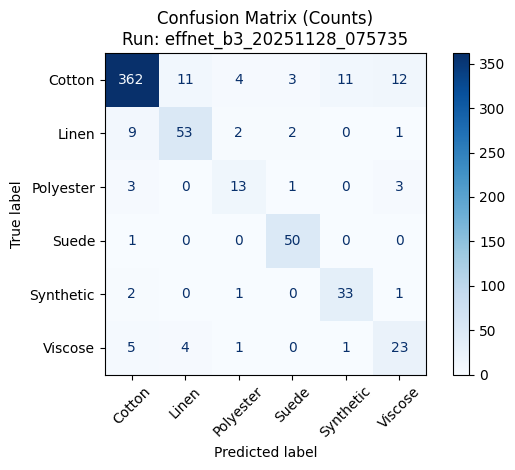

<Figure size 1000x800 with 0 Axes>

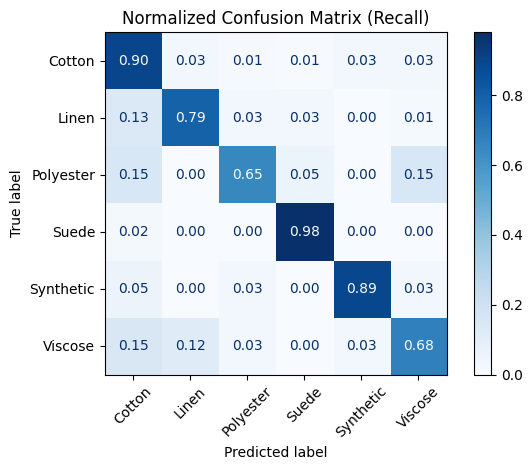

In [ ]:
# ============================================================================
# Visualization: Confusion Matrix
# ============================================================================
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import pandas as pd
from pathlib import Path
import numpy as np

# ensure run_id is defined (from previous cells)
if 'run_id' in locals():
    # Load predictions from the last run
    pred_path = Path(f"461 project/{run_id}/predictions_fold0.csv")

    if pred_path.exists():
        print(f" Loading predictions from {pred_path}...")
        df = pd.read_csv(pred_path)
        y_true = df['true_label']
        y_pred = df['predicted_label']

        # Get class names from label_mapping if available
        if 'label_mapping' in locals():
            # Sort by index to ensure correct order
            display_labels = [name for name, idx in sorted(label_mapping.items(), key=lambda x: x[1])]
        else:
            display_labels = sorted(df['true_label'].unique())

        cm = confusion_matrix(y_true, y_pred)

        plt.figure(figsize=(10, 8))
        disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
        disp.plot(cmap='Blues', values_format='d', xticks_rotation=45)
        plt.title(f'Confusion Matrix (Counts)\nRun: {run_id}')
        plt.tight_layout()
        plt.show()

        # This helps visualize "What % of Linen was misclassified as Cotton?"
        cm_norm = confusion_matrix(y_true, y_pred, normalize='true')

        plt.figure(figsize=(10, 8))
        disp_norm = ConfusionMatrixDisplay(confusion_matrix=cm_norm, display_labels=display_labels)
        disp_norm.plot(cmap='Blues', values_format='.2f', xticks_rotation=45)
        plt.title(f'Normalized Confusion Matrix (Recall)')
        plt.tight_layout()
        plt.show()

    else:
        print(f" Could not find predictions at {pred_path}")
else:
    print(" run_id not defined. Please ensure you have run the training cell.")

In [ ]:
!pip install grad-cam

from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 96.3 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=ca02dda9d3d523798a3738bdf1969262404124c30c196c2382c1898eafdffd6b
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
from pathlib import Path
import torchvision.transforms as transforms
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# --- FIX: Set BACKBONE_USED to match the trained model's backbone ---
# The training run (from cell 30e3cfea) used CONFIG['backbone'], which was 'eva02_base'
# from the CONFIG variable in cell b8ed7556.
BACKBONE_USED = "eva02_base" # Changed from "efficientnet_b3"
AGG_TYPE_USED = "gated_attention"

run_id = "effnet_b3_20251128_075735"   # same as in your eval cell
fold_to_visualize = 0

path_prefix = "/content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/"
save_dir_path = Path(path_prefix) / run_id
checkpoint_path = save_dir_path / f"best_model_fold{fold_to_visualize}.pth"

print("Looking for checkpoint at:", checkpoint_path)

if not checkpoint_path.exists():
    raise FileNotFoundError(f"Checkpoint not found at {checkpoint_path}")

print(f" Loading model from {checkpoint_path}...")

model_viz = MIL_FabricClassifier(
    n_classes=len(label_mapping),
    agg_type=AGG_TYPE_USED,
    backbone=BACKBONE_USED,
    n_mid=1024,
    dropout=0.5,
).to(device)

ckpt = torch.load(checkpoint_path, map_location=device)
model_viz.load_state_dict(ckpt["model_state_dict"])
model_viz.eval()
print(" Model loaded successfully.")

# --- tiny visualization dataset from a few test bags ---
test_items_sample = {k: data_dict[k] for k in list(data_dict.keys())[:5]}

test_dataset_viz = FabricMILDataset(
    test_items_sample,
    pre_transform=transforms.Compose([
        pad_to_square,
        transforms.Resize((PRE_RESIZE, PRE_RESIZE)),
    ]),
    transform=transforms.Compose([
        transforms.RandomResizedCrop(
            IMAGE_SIZE,
            scale=(CROP_SCALE_MIN, CROP_SCALE_MAX),
            ratio=(0.9, 1.1),
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225],
        ),
    ]),
    cache=False,            # no need to cache for just a few bags
    n_crops_per_image=8,
)

print(f" Visualization dataset ready with {len(test_dataset_viz)} bags.")


Using device: cuda
Looking for checkpoint at: /content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/effnet_b3_20251128_075735/best_model_fold0.pth
 Loading model from /content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/effnet_b3_20251128_075735/best_model_fold0.pth...
 Loading backbone: eva02_base_patch14_224.mim_in22k (feature_dim=768)
 Model loaded successfully.
 Visualization dataset ready with 5 bags.


In [ ]:
class MILWrapper(nn.Module):
    def __init__(self, mil_model, bag_id="tmp"):
        super().__init__()
        self.mil_model = mil_model
        self.bag_id = bag_id

    def forward(self, x):
        # x: [B, C, H, W]  (we treat the batch as a bag of B instances)
        bag_dict = {self.bag_id: x}
        # Explicitly enable gradients for this pass to allow Grad-CAM to work,
        # even if the underlying mil_model is in eval() mode and has set_grad_enabled(False)
        with torch.enable_grad():
            y_pred, _, _ = self.mil_model(bag_dict)
        return y_pred

wrapped_model = MILWrapper(model_viz).to(device)
wrapped_model.eval()
print(" Wrapped model ready for Grad-CAM")

 Wrapped model ready for Grad-CAM


Backbone type: <class 'timm.models.eva.Eva'>
Bag ID: item_3
True label: 4 (Synthetic)
Predicted: 4 (Synthetic)
Using crop with highest attention index: 13


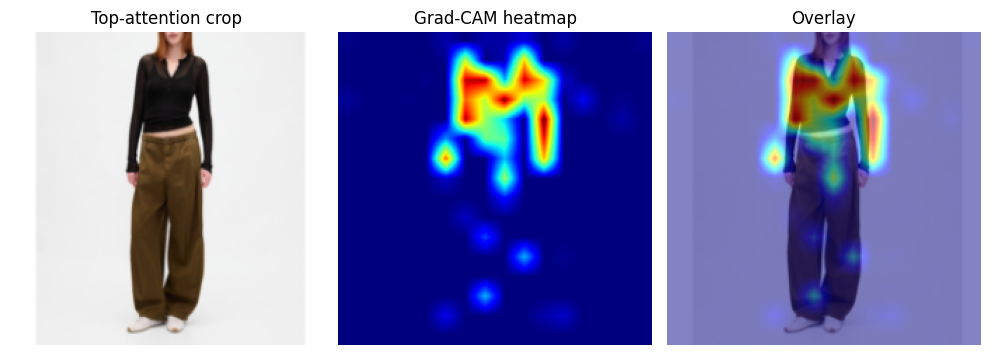

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# target layer: last conv before global pooling in EfficientNet-B3
backbone = model_viz.feature_extractor
print("Backbone type:", type(backbone))

# FIX: For ViTs, we need a reshape_transform to convert token-based features
# into a spatial grid. Targeting the last block's normalization layer.
target_layers = [backbone.blocks[-1].norm1]

def reshape_transform(tensor, num_patches_side=16, num_tokens_to_skip=1):
    # tensor shape: (batch_size, num_tokens, channel)
    # Example: (1, 257, 768) for 224x224 input, 14x14 patches (224/14=16 patches per side)
    # Skip the CLS token (if present) and reshape the remaining patches into a grid
    result = tensor[:, num_tokens_to_skip:, :].reshape(
        tensor.size(0),
        num_patches_side, # height
        num_patches_side, # width
        tensor.size(2)    # channels
    )
    # Permute to (batch_size, channel, H, W) for Grad-CAM
    result = result.permute(0, 3, 1, 2)
    return result


cam = GradCAM(
    model=wrapped_model,
    target_layers=target_layers,
    reshape_transform=reshape_transform # Add reshape_transform for ViT
)

# ----- pick a bag to visualize -----
bag_idx = 2  # change this to inspect other products
bag_id, bag_tensor, bag_label = test_dataset_viz[bag_idx]  # Corrected: item_id, instances_tensor, label

bag_tensor = bag_tensor.to(device)
bag_tensor.requires_grad_(True)

# Run once through MIL model to get attention + prediction
bag_dict = {bag_id: bag_tensor}
with torch.no_grad():
    y_pred, bag_info, _ = model_viz(bag_dict)

logits = y_pred[0]
pred_class = logits.argmax().item()

print(f"Bag ID: {bag_id}")
print(f"True label: {bag_label.item()} ({reverse_mapping[bag_label.item()]})") # Convert tensor to int with .item()
print(f"Predicted: {pred_class} ({reverse_mapping[pred_class]})")

# ----- pick crop: highest-attention instance -----
if isinstance(bag_info[bag_id], torch.Tensor):
    attn = bag_info[bag_id].to(device)   # [n_crops]
    top_idx = attn.argmin().item() # change to argmin for worst
    print(f"Using crop with highest attention index: {top_idx}")
else:
    top_idx = 0
    print("Attention not available, using first crop (index 0)")

inst_img = bag_tensor[top_idx]          # [C, H, W]
inst_img_batch = inst_img.unsqueeze(0)  # [1, C, H, W]

targets = [ClassifierOutputTarget(pred_class)]

# Temporarily set model to train mode to enable gradient computation for feature_extractor
original_training_state = model_viz.training
model_viz.train()

grayscale_cam = cam(input_tensor=inst_img_batch, targets=targets)[0]  # [H, W]

# Restore original training state
model_viz.training = original_training_state
model_viz.eval()

# ----- de-normalize image -----
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(inst_img.device)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(inst_img.device)
inst_denorm = (inst_img * std + mean).clamp(0, 1).detach().cpu()

img_np = inst_denorm.permute(1, 2, 0).numpy().astype(np.float32)

# ----- overlay Grad-CAM -----
visualization = show_cam_on_image(img_np, grayscale_cam, use_rgb=True)

# Use plt.subplots for explicit figure and axes management
fig, axes = plt.subplots(1, 3, figsize=(10, 4))

axes[0].imshow(img_np)
axes[0].axis("off")
axes[0].set_title("Top-attention crop")

axes[1].imshow(grayscale_cam, cmap="jet")
axes[1].axis("off")
axes[1].set_title("Grad-CAM heatmap")

axes[2].imshow(visualization)
axes[2].axis("off")
axes[2].set_title("Overlay")

plt.tight_layout()
plt.show()

In [ ]:
from pathlib import Path
import torch
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import defaultdict
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image

# ===================================================
# SETTINGS
# ===================================================
MAX_VIZ_BAGS = 100  # limit visualized dataset size

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_viz.to(device).eval()
wrapped_model.to(device).eval()
print("Using:", device)

# ===================================================
# Build reduced visualization dataset (≤100 bags)
# ===================================================
all_items = list(data_dict.items())
reduced_items = dict(all_items[:MAX_VIZ_BAGS])

print(f"Reduced visualization dataset → {len(reduced_items)} bags")

test_dataset_viz = FabricMILDataset(
    reduced_items,
    pre_transform=transforms.Compose([
        pad_to_square,
        transforms.Resize((PRE_RESIZE, PRE_RESIZE)),
    ]),
    transform=transforms.Compose([
        transforms.RandomResizedCrop(
            IMAGE_SIZE,
            scale=(CROP_SCALE_MIN, CROP_SCALE_MAX),
            ratio=(0.9, 1.1),
        ),
        transforms.ToTensor(),
        transforms.Normalize(
            [0.485, 0.456, 0.406],
            [0.229, 0.224, 0.225],
        ),
    ]),
    cache=False,
    n_crops_per_image=4, # keep runtime down
)

# ===================================================
# Class → dataset index
# ===================================================
class_to_indices = defaultdict(list)
for idx in range(len(test_dataset_viz)):
    bag_id, bag_tensor, bag_label = test_dataset_viz[idx]
    class_to_indices[int(bag_label)].append(idx)

print("Available per class:", {reverse_mapping[k]: len(v) for k,v in class_to_indices.items()})

# ===================================================
# EVA reshape transform + Grad-CAM setup
# ===================================================
def eva_reshape_transform(tensor):
    B, N, C = tensor.shape
    hw = N - 1
    side = int(hw ** 0.5)
    assert side * side == hw, f"Bad token shape for EVA: {tensor.shape}"
    return tensor[:, 1:, :].reshape(B, side, side, C).permute(0, 3, 1, 2)

backbone = model_viz.feature_extractor
target_layers = [backbone.blocks[-1].norm1]
cam = GradCAM(
    model=wrapped_model,
    target_layers=target_layers,
    reshape_transform=eva_reshape_transform,
)

# ===================================================
# Utilities
# ===================================================
mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1).to(device)
std  = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1).to(device)
def to_np(t): return ((t * std + mean).clamp(0,1).cpu().permute(1,2,0).numpy())

def gradcam_crop(crop, cls):
    targets = [ClassifierOutputTarget(cls)]
    return cam(input_tensor=crop.unsqueeze(0), targets=targets)[0]

# ===================================================
# Best/Worst visualization for a bag index
# ===================================================
def run_best_worst(bag_idx, save_dir):
    bag_id, bag, label = test_dataset_viz[bag_idx]
    bag = bag.to(device)

    # 1. Get prediction and attention from model_viz (for best/worst crop selection)
    # This pass is for inference, so no_grad is appropriate.
    with torch.no_grad():
        y_pred_inference, bag_info_dict_inference, _ = model_viz({bag_id: bag})

    logits = y_pred_inference[0]
    pred_cls = logits.argmax().item()
    true_cls = int(label)

    # Ensure attention is available
    if bag_info_dict_inference and bag_id in bag_info_dict_inference:
        attn = bag_info_dict_inference[bag_id].to(device)
        best_idx = attn.argmax().item()
        worst_idx = attn.argmin().item()
    else:
        # Fallback if attention isn't directly produced or is empty
        best_idx = 0
        worst_idx = 0
        print(f"Warning: No attention data for {bag_id}, using first/last crop for Grad-CAM.")

    # 2. Compute GradCAM for selected crops.
    # Temporarily set model_viz to train mode to enable gradient tracking in feature_extractor
    original_training_state_mil_model = model_viz.training
    model_viz.training = True

    # Call gradcam_crop which uses the `cam` object, which internally calls `wrapped_model.forward()`
    best_cam = gradcam_crop(bag[best_idx], pred_cls)
    worst_cam = gradcam_crop(bag[worst_idx], pred_cls)

    # Restore original training state
    model_viz.training = original_training_state_mil_model
    model_viz.eval() # Ensure it's back in eval mode for future inference if needed

    best_img = to_np(bag[best_idx])
    worst_img = to_np(bag[worst_idx])

    best_overlay = show_cam_on_image(best_img, best_cam, use_rgb=True)
    worst_overlay = show_cam_on_image(worst_img, worst_cam, use_rgb=True)

    # Clear previous figure states before plotting
    plt.clf()
    plt.close('all')

    fig, axes = plt.subplots(2, 3, figsize=(10,7))

    for ax, img, title in [
        (axes[0,0], best_img, "Best crop"),
        (axes[0,1], best_cam, "Best heatmap"),
        (axes[0,2], best_overlay, "Best overlay"),
        (axes[1,0], worst_img, "Worst crop"),
        (axes[1,1], worst_cam, "Worst heatmap"),
        (axes[1,2], worst_overlay, "Worst overlay")]:

        ax.imshow(img if img.ndim==3 else img, cmap="jet" if img.ndim==2 else None)
        ax.set_title(title)
        ax.axis("off")

    fig.suptitle(f"{reverse_mapping[true_cls]} (true) → {reverse_mapping[pred_cls]} (pred)", fontsize=12)
    plt.tight_layout()

    save_dir.mkdir(parents=True, exist_ok=True)
    fname = f"{reverse_mapping[true_cls]}_bag{bag_idx}.png"
    fig.savefig(save_dir / fname, dpi=200)
    plt.close(fig)

# ===================================================
# Run: one visualization per class
# ===================================================
out_dir = Path(path_prefix) / run_id / "gradcam_best_worst"
print("Saving results to:", out_dir)

for cls in range(len(label_mapping)):
    if cls not in class_to_indices or len(class_to_indices[cls]) == 0:
        print(f"Skipping class {reverse_mapping[cls]} — no examples")
        continue

    bag_to_use = class_to_indices[cls][0]  # just one per class
    print(f"Processing class {reverse_mapping[cls]} → bag index {bag_to_use}")
    run_best_worst(bag_to_use, out_dir)

print("✨ Done — per-class Grad-CAM overlays saved!")


Using: cuda
Reduced visualization dataset → 100 bags
Available per class: {'Synthetic': 22, 'Cotton': 78}
Saving results to: /content/drive/MyDrive/CSCI 461 Project/cynthia-model/results/effnet_b3_20251128_075735/gradcam_best_worst
Processing class Cotton → bag index 22
Skipping class Linen — no examples
Skipping class Polyester — no examples
Skipping class Suede — no examples
Processing class Synthetic → bag index 0
Skipping class Viscose — no examples
✨ Done — per-class Grad-CAM overlays saved!
